# Анализ сайта «СберАвтоподписка» (ML проект)

## Задача:
Задача:
- предсказать совершение целевого действия (ориентировочное значение ROC-AUC ~ 0.65)
- упаковать получившуюся модель в сервис, который будет брать на вход все атрибуты, типа utm_*, Wevice_*, geo_*, и отдавать на выход 0/1 (1 - если пользователь совершил целевое действие)
- Формат файла — (минимум) .py-скрипт с инструкциIй по локальному запуску или (максимум) localhost web app.
- Содержание — модель, берущая на вход строку с данными по визиту (согласно схеме данных) и отдающая на выход результат предсказания по отдельному событию в числовом формате 0|1

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

import statistics as st
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
from scipy import stats
from scipy.stats import mode

import pickle

In [15]:
import warnings
warnings.filterwarnings('ignore')

## Оглавление
- Исходные данные
- 0. Общие функции
- 1. EDA
    - 1.1. ИССЛЕДОВАНИЕ ИСХОДНОГО ФАЙЛА 'ga_hits.csv'
        - 1.1.1. Общие данные по файлу
        - 1.1.2. Заполнение таблицы для работы, проверка качества заполнения, расчет параметра CR ('ga_hits.csv')
        - 1.1.3. Группировка по id и расчет суммарного CR  ('ga_hits.csv')
        - 1.1.4. Определение признака марки и модели авто -- "model_auto" 
            - 1.1.4.1. Выделение и группировка данных по марке и модели авто 
            - 1.1.4.2. Исследование популярности марки авто
            - 1.1.4.3. Стандартизация категориальной переменной марки авто
    - 1.2.  ИССЛЕДОВАНИЕ ИСХОДНОГО ФАЙЛА 'ga_sessions.csv'
        - 1.2.1.  Присоединение параметра конверсии - "CR"
    - 1.3.  DATA CLEANING рабочей выборки 
        - 1.3.1. Исследование исходных данных
        - 1.3.2. Работа с отсутствующими  и нулевыми данными 
            - 1.3.2.1. Удаление столбцов с отсутств.данными >20% -'device_model','_merge', 'utm_keyword', 'device_os'
            - 1.3.2.2. Проверка объема нулевых значений по столбцам таблицы ('(not set)' или 'none')
            - 1.3.2.3. Работа со столбцами с отсутствующими и нулевыми значениями (8 столбцов)
            - 1.3.2.4.  Проверка результатов 
        - 1.3.3.  Преобразование типов данных
            - 1.3.3.1.  Преобразование столбцов даты и времени визита 
        - 1.3.4. Удаление "лишних" столбцов
- 2. FEATURE ENGINEERING
    - 2.1. Формирование дополнительных, необходимых для анализа, столбцов
        - 2.1.1. Формирование доп. столбцов - 'CR_result'(0/1), 'org_traffic', 'advertising_social_NW, 'advertising_social_NW
        - 2.1.2. Преобразование 'client_id', 'date', добавление столбцов дат 'month' и 'dayofweek'
        - 2.1.3. Преобразование категориальных - 'device_screen_resolution', 'device_browser', 'device_brand', 'utm_campaign',  'utm_source', 'geo_city' 
        - 2.1.4. Выводы по разделу 2.1.
    - 2.2. Исследование распределения конверсии во времени
    - 2.3. Исследование корреляции признаков
    - 2.4. Стандартизация и нормализация данных
        - 2.4.1. Стандартизация категориальных переменных
        - 2.4.2. Стандартизация количественных переменных
- 4. Modelling
    - 4.1. Исследование выборки 1 (общая, без сокращения признаков, без моделей авто)
        - 4.1.1. Подготовка данных
        - 4.1.2 Обучение моделей разными методами - Логистическая регрессия, Случайный лес, Многослойный персептрон
        - 4.1.3. Кросс-валидация на тренировочной выборке
        - 4.1.4. Выбор лучшей модели на выборке 1
    - 4.2. Исследование моделей на второй выборке (с сокращением признаков, без моделей авто)
        - 4.2.1. Сокращение признаков, подготовка данных
        - 4.2.2.  Обучение моделей разными методами - Логистическая регрессия, Случайный лес, Многослойный персептрон
        - 4.2.3. Кросс-валидация на тренировочной выборке
        - 4.2.4. Выбор лучшей модели на выборке 2
    - 4.3. Исследование моделей на третьей выборке (с сокращением признаков, с моделями авто)
        - 4.3.1. Подготовка данных
        - 4.3.2 Обучение моделей разными методами - Логистическая регрессия, Случайный лес, Многослойный персептрон
        - 4.3.3. Кросс-валидация на тренировочной выборке
        - 4.3.4. Выбор лучшей модели на выборке 3
- 5. RESULTS
    - 5.1. Общие выводы по модели
    - 5.2. Подготовка к общему использованию

## Исходные данные
Файл GA Sessions (ga_sessions.pkl)  --- одна строка = один визит на  сайт
Файл  GA Hits (ga_hits.pkl)   --- Одна строка = одно событие в рамках одного визита на сайт

## 0. Общие функции 

In [16]:
# Функция вывода содержание таблицы: количество уникальных значений в столбцах, их список
def df_info_(df):
    print('Размер выборки -', df.shape)
    print('Состав выборки -', df.columns)
    return df.head(3)

In [17]:
# Функция вывода общей информации  по столбцам выборки по уникальным значениям  и их кол-ве
def df_info_uniq(df):
    for column in df:
        print('')
        print('Характеристика:', column)
        uniqvalue = df[column].nunique()
        print('Количество уникальных значений: ', uniqvalue)
        print('Список значений: ',  df[column].value_counts())

In [18]:
# Функция выводы процента пропущенных значений по всем столбцам датафрейма по возрастанию
def missing_values(df):
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
    print('Процент пропущенных значений:')
    return missing_values

In [19]:
# Функция оценки количества заполненных объектов в выборке
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки: ', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки: ', round(len(df.dropna())/len(df) * 100, 2))

In [20]:
# Функция выделения модели авто
def model_au(s):
    if len(s.split(sep=('/'))) >= 3:  
        if s.split(sep=('/'))[1] == 'cars':
            if s.split(sep=('/'))[2] == 'all':
                model_ = s.split(sep=('/'))[3]+' '+s.split(sep=('/'))[4]
                if len(model_)!= 8:
                    return model_
                else :
                    model_ = 'none'
                    return model_
            else :
                str_list = s.split(sep='?')[0]
                model_ = str_list.split(sep=('/'))[2]
                if len(model_) != 8:
                    return model_
                else:
                    model_ = 'none'
                    return model_
        else :
            model_ = 'none'
            return model_
    else :
        model_ = 'none'
        return model_

In [21]:
def check_none_values (df):
    df_ = list(df.columns)
    num = np.array(df_)
    c = len(df.columns)
    df__ = pd.DataFrame(num.reshape(c,1), columns=['columns'])
    result = []
    for column in df:
        none_values = ((len(df[((df[column]=='(not set)') | (df[column]=='none') | (df[column]=='(none)'))])/len(df))*100)
        result.append(none_values)  
    df__['result']=result
    print('Проверка % нулевых значений объектов из всей выборки (проверка нулевых данных): ')
    return df__.sort_values('result', ascending=False)

In [22]:
# Замена отсутствующих значений на моду столбца, сформированную через группировку по другому столбцу
def re_moda_group(df, st_group, st_res):
    df_mod_gr = df.groupby(st_group)[st_res].agg(res_mode = st.mode)
    df_mod_gr['res_mode'] = df_mod_gr['res_mode'].astype('string')
    df = df.merge(df_mod_gr, on = st_group, how='outer', indicator=False)
    df[st_res] = replace_isna_data (df[st_res],df['res_mode'])
    return df[st_res]

In [23]:
# Функция замены отсутствующих данных на значение другого столбца этой же таблицы и проверка результата
# пустые значения df1 меняем на значения df2
def replace_isna_data (df1,df2):                             
    df1= df1.fillna(df2)
    print('Итоговый процент отсутствующих значений после замены: ', (df1.isna().sum()/(len(df1)))*100)
    return df1

In [24]:
# Функция замены отсутствующих данных на моду всего столбца и проверка результата
def replace_isna_data_all_column_mode(df):
    x = df.mode()[0]
    df = df.fillna(x)
    print("Итоговый процент отсутствующих значений после замены на моду столбца - ", df.isna().sum())
    return df

In [25]:
# Функция замены нулевых значений, т.е. равных '(not set)' или 'none',на моду всего столбца 
def replace_none_data_all_column_mode(df):
    x = df.mode()[0]
    df = df.replace(['(not set)', 'none','(none)'], x) 
    return df
# Функция проверки наличия нулевых значений в столбце, т.е. равных '(not set)' или 'none'
def none_value (df):
    none_value = ((len(df[((df=='(not set)') | (df=='none') | (df=='(none)'))])/len(df))*100)
    return print('Процент нулевых значений: ', none_value)

In [26]:
# Функция замены нулевых данных на значение другого столбца этой же таблицы  и в остатке на заданное значение 
def re_moda_group_none(df, st_group, st_res, nul_mode):
    df_mod_gr = df.groupby(st_group)[st_res].agg(res_mode = st.mode)
    df_mod_gr['res_mode'] = df_mod_gr['res_mode'].astype('string')
    df = df.merge(df_mod_gr, on = st_group, how='outer', indicator=False)
    df[st_res] = np.where(((df[st_res] == '(not set)') | (df[st_res] == '(none)') | (df[st_res] == 'none')), df['res_mode'], df[st_res]) 
    df[st_res] = df[st_res].replace(['(not set)', 'none','(none)'], nul_mode) 
    none_value(df[st_res])
    return df[st_res]

In [27]:
# Функция замены нулевых значений, т.е. равных '(not set)' или 'none',на моду всего столбца 
def replace_none_data_all_column_mode(df):
    x = df.mode()[0]
    df = df.replace(['(not set)', 'none','(none)'], x) 
    return df

In [28]:
# Функция проверки наличия нулевых значений в столбце, т.е. равных '(not set)' или 'none'
def none_value (df):
    none_value = ((len(df[((df=='(not set)') | (df=='none') | (df=='(none)'))])/len(df))*100)
    return print('Процент нулевых значений: ', none_value)

In [29]:
# Функция проверки наличия только числовых значений в текстовой ячейке столбца таблицы
def numer(df):
    g = 0
    for i in range(len(df)):
        if df[i].isnumeric() == True:
            g = g+1
        else:
            g = g+0
    return (print('Числовых значений нет') if g == 0  else print(('Числовых значений - '), g))

In [30]:
# Функция проверки процента полностью заполненных объектов в итоговой таблице
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки: ', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки: ', round(len(df.dropna())/len(df) * 100, 2))

In [31]:
# Функция группировки по выделенному столбцу и подсчетом количества элементов по выборке и суммы по конверсии
# определение лидеров 
def gr_CR_and_count(df, column):
    d = df.groupby([column]).agg({'session_id': 'size', 'CR_result': 'sum'}).reset_index().rename(columns={'session_id': 'count', 'CR_result': 'count_CR'}).sort_values(by='count_CR', ascending = False)
    return d

In [32]:
# Функция визуализации результатов выборки лидеров
def vis_leaders_count_CR(df, column, name):
    print(name)
    df_ = df[0:10]
    plt.figure(1)
    plt.figure(figsize=(20, 3))
    plt.bar(df_[column], df_['count'])
    plt.ylabel('Количество')
    plt.title('10 лидеров распределения')
    plt.show();
    plt.figure(2)
    plt.figure(figsize=(20, 3))
    plt.bar(df_[column], df_['count_CR'])
    plt.xlabel(name)
    plt.ylabel('Количество')
    plt.title('10 лидеров распределения  конверсии в целевое действие')
    plt.show();

In [33]:
# Функция вывода метрики точности accuracy для тренировочной и тестовой моделей
def accur_train_test(predicted_train, predicted_test, y_train, y_test):
    print(f'TRAIN ACC: {accuracy_score(y_train, predicted_train)}')
    print(f'TEST ACC: {accuracy_score(y_test, predicted_test)}')

In [119]:
# функция предсказания обученной модели на тренировочном и тестовом датасетях, вывода точности предсказания и Сonfusion_matrix
def mod_pred(mod, X_train, y_train, X_test, y_test, name):
    predicted_train_res_mod = mod.predict(X_train)
    predicted_test_res_mod = mod.predict(X_test)
    print('Модель  --', name)
    print('Показатели точности модели --')
    accur_train_test(predicted_train_res_mod, predicted_test_res_mod, y_train, y_test)
    print('Сonfusion_matrix -\n', confusion_matrix(y_test, predicted_test_res_mod))

# функция вывода параметров и кривой  ROC-AUC
def roc_auc_test(mod, X, y):
    y_pred_proba = mod.predict_proba(X)[::,1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    auc = roc_auc_score(y, y_pred_proba)
    plt.figure(figsize=(5, 3))
    plt.plot(fpr,tpr,label =" AUC= "+str(auc))
    plt.legend(loc = 4)
    plt.show()     

In [35]:
# функция кросс валидации на тренировочной выборке
def cross_val(mod, X_train, y_train, cv_n, name_model):
    print('Показатели после кросс-валидации модели ---', name_model)
    print(cross_validate(mod, X_train, y_train, cv = cv_n))
    cv_score_mod = cross_val_score(mod, X_train, y_train, cv = cv_n)
    print( "Cреднее значение точности модели - ", cv_score_mod.mean()*100, "%",  
          "\nСтандартное отклонение точности модели -", cv_score_mod.std())
    return cv_score_mod

## 1. EDA
### 1.1. ИССЛЕДОВАНИЕ ИСХОДНОГО ФАЙЛА 'ga_hits.csv'
Проверен файл с расширением .pkl, его содержание аналогично, поэтому сразу работаем с ga_hits.csv

#### 1.1.1. Общие данные по файлу

In [26]:
df_out = pd.read_csv('data/ga_hits.csv')
df_info_(df_out)

Размер выборки - (15726470, 11)
Состав выборки - Index(['session_id', 'hit_date', 'hit_time', 'hit_number', 'hit_type',
       'hit_referer', 'hit_page_path', 'event_category', 'event_action',
       'event_label', 'event_value'],
      dtype='object')


,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN


ga_hits.csv  - одна строка = одно событие в рамках одного визита на сайт

1. session_id - ID визита
2. hit_date  - дата события
3. hit_time - время события 
4. hit_number - порядковый номер события в рамках сессии
5. hit_type - тип события
6. hit_referer - источник события
7. hit_page_path - страница события
8. event_category - тип действия
9. event_action - действие
10. event_label - тег действия
11. event_value - значение результата действия

In [17]:
# Смотрим содержание таблицы: количество уникальных значений в столбцах, их список
df_info_uniq(df_out)


Характеристика: session_id
Количество уникальных значений:  1734610
Список значений:  5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
                                            ... 
4570994095441102117.1630324006.1630324006      1
768506153535315810.1630314342.1630314342       1
5517253735248338264.1630315080.1630315080      1
4054272189286640867.1630334209.1630334209      1
5381267721977892188.1640271196.1640271196      1
Name: session_id, Length: 1734610, dtype: int64

Характеристика: hit_date
Количество уникальных значений:  226
Список значений:  2021-05-24    513035
2021-12-21    280192
2021-05-25    235805
2021-09-23    168899
2021-05-26    158382
               ...  
2021-07-24     23490
2021-05-23     18773
2021-05-19     14605
2021-05-22     13917
2021-05-21     13497
Name: hit_date

<AxesSubplot:>

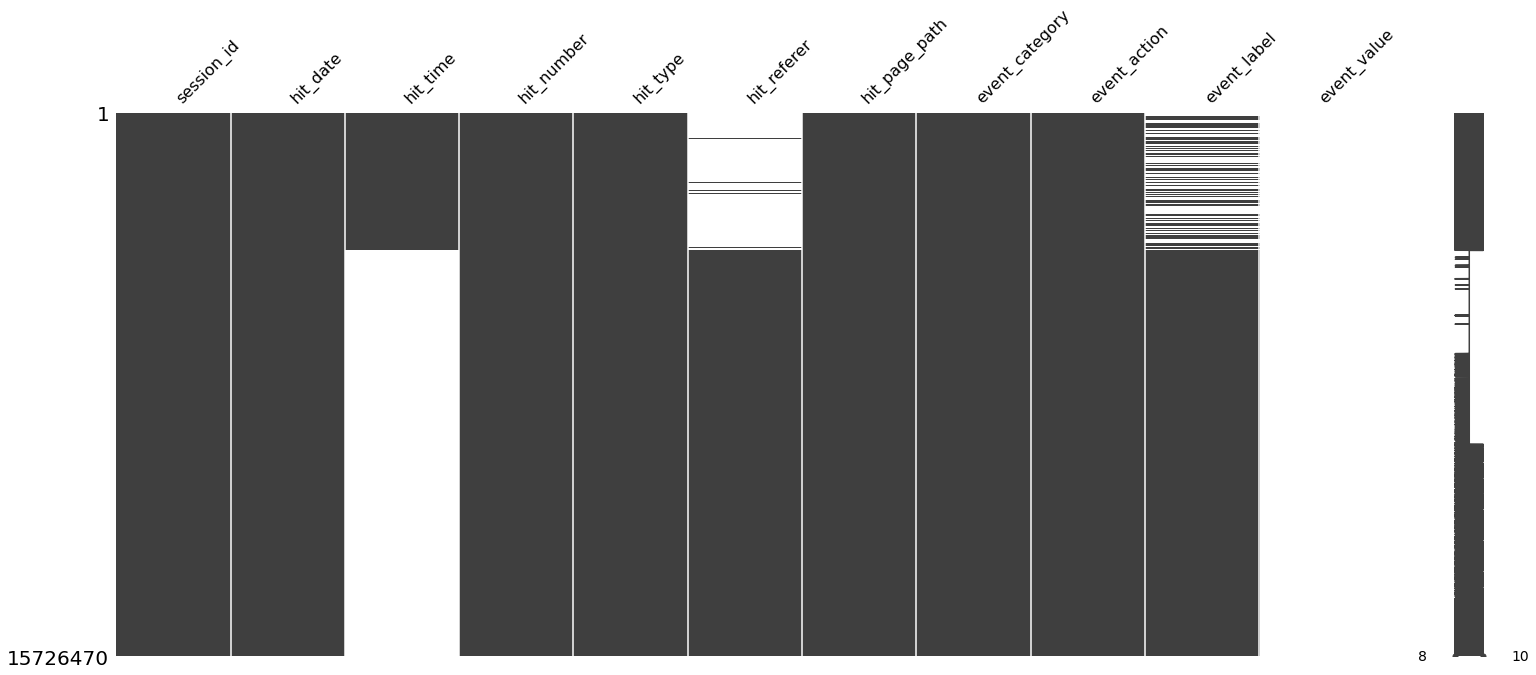

In [18]:
# Изучаем визуальное отображение полноты данных таблицы
msno.matrix(df_out)

In [22]:
# Проверим количество пропущенных значений по столбцам
missing_values(df_out)

Процент пропущенных значений:


event_value       100.000000
hit_time           58.247795
hit_referer        39.899634
event_label        23.909905
session_id          0.000000
hit_date            0.000000
hit_number          0.000000
hit_type            0.000000
hit_page_path       0.000000
event_category      0.000000
event_action        0.000000
dtype: float64

- 7 колонок из 11 заполнены на 100%

- 4 колонки не заполнены полностью (от 24 до 100%)

- колонка event_value не заполнена совсем (100% данных отсутствуют)

Все четыре колонки ('event_value', 'hit_time', 'hit_referer', 'event_label') для дальнейших действий не нужны,
поэтому их можно удалить

#### 1.1.2. Заполнение таблицы для работы, проверка качества заполнения, расчет параметра CR ('ga_hits.csv')

In [27]:
# Удаляем столбцы с пропущенными данными, проверяем итоговую размерность таблицы, а также процент заполнения выборки
columns_for_drop = ['event_value', 'hit_time', 'hit_referer', 'event_label']
df_prepared = df_out.drop(df_out[columns_for_drop], axis =1)
print(df_prepared.shape)
print_useful_rows_info(df_prepared)

(15726470, 7)
Количество полностью заполненных объектов из всей выборки:  15726470
Процент полностью заполненных объектов из всей выборки:  100.0


Формируем столбец CR (Convercion Rate) - конверсия из визита в любое целевое действие из списка:  

Целевое действие — события типа «Оставить заявку» и «Заказать звонок» 
- (ga_hits.event_action in ['sub_car_claim_click', 'sub_car_claim_submit_click', 
'sub_open_dialog_click', 'sub_custom_question_submit_click', 
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']

In [28]:
# Формируем столбец CR (Convercion Rate)
df_prepared['CR'] = [1 if (x == 'sub_car_claim_click' or x =='sub_car_claim_submit_click' or x =='sub_open_dialog_click'
    or x =='sub_custom_question_submit_click' or x =='sub_call_number_click'
    or x =='sub_callback_submit_click' or x =='sub_submit_success' or x =='sub_car_request_submit_click')
    else 0 for x in df_prepared['event_action']]
# Проверяем количество целевых действий и их уникальность 
print('Количество уникальных значений: ', df_prepared['CR'].nunique())
print('Список значений: ',  df_prepared['CR'].value_counts())

Количество уникальных значений:  2
Список значений:  0    15621562
1      104908
Name: CR, dtype: int64


 ##### Целевых действий CR   ---     из 15 726 470    -  всего лишь 104 908, т.е. 0,67%

####  1.1.3.  Группировка по id и расчет суммарного CR  ('ga_hits.csv')

In [29]:
# Для работы принимаем значение 'CR_sum', 'CR_count' принимаем к сведению
df_group_CR_sum = df_prepared.groupby('session_id')['CR'].sum().reset_index(name='CR_sum').sort_values(['CR_sum'], ascending=False)
print(df_group_CR_sum.shape)
df_group_CR_sum.head(3)

(1734610, 2)


,session_id,CR_sum
1281576,7140505447604038223.1630415440.1630415440,474
286145,2375944964542858067.1635025747.1635025747,83
676515,4245963133837464050.1640882501.1640882501,81


#### 1.1.4. Определение признака марки и модели авто -- "model_auto" 
###### 1.1.4.1. Выделение и группировка данных по марке и модели авто

In [25]:
# Создаем столбец модели авто
df_prepared['model_auto'] = df_prepared['hit_page_path'].apply(model_au)
df_prepared.head(3)
# Смотрим структуру нового столбца моделей авто
df_prepared_auto = df_prepared
print('Количество уникальных значений: ', df_prepared_auto['model_auto'].nunique())
print('Список значений: ',  df_prepared_auto['model_auto'].value_counts())

Количество уникальных значений:  148
Список значений:  none               12217738
skoda rapid          442513
lada-vaz vesta       403910
volkswagen polo      318075
skoda karoq          194273
                     ...   
saab                      1
ravon                     1
haima                     1
seat                      1
dacia                     1
Name: model_auto, Length: 148, dtype: int64


In [ ]:
# Исключаем из выборки для увеличения скорости обработки данных строки с нулевым значением марки авто (= 'none')
df_auto_without_none = df_prepared_auto.drop(df_prepared_auto[(df_prepared_auto.model_auto == 'none')].index)
df_auto_without_none_ = df_auto_without_none.drop(df_auto_without_none[(df_auto_without_none.model_auto == '')].index)

In [ ]:
# Сохраняем промежуточный файл с марками авто
df_auto_without_none_.to_csv('data/df_auto_without_none_.csv', index = False)

###### 1.1.4.2.  Исследование популярности марки авто и формирование выборки с моделями авто

Размерность выборки с моделями авто (146, 3)
Лидеры среди моделей автомобилей


<Figure size 432x288 with 0 Axes>

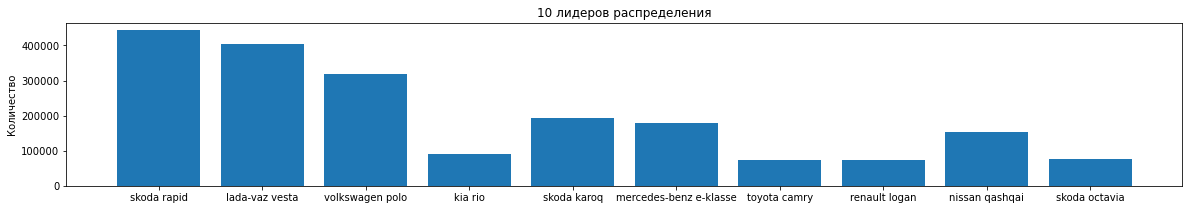

<Figure size 432x288 with 0 Axes>

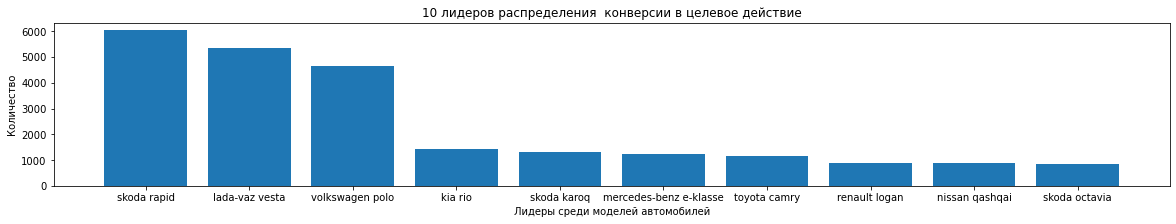

In [31]:
df1 = pd.read_csv('data/df_auto_without_none_.csv')
df1['CR_result'] = df1['CR']
# Делаем группировку по моделям авто с подсчетом общего количества сессий и количества конверсий в результат
stats_auto = gr_CR_and_count(df1, 'model_auto')
print('Размерность выборки с моделями авто', stats_auto.shape)
# Визуализируем лидеров 
vis_leaders_count_CR(stats_auto, 'model_auto', 'Лидеры среди моделей автомобилей')

In [27]:
# Считаем корреляцию признаков целевой переменной и модели авто по коэффициенту Спирмена
stats.spearmanr(df_auto_without_none['CR'], df_auto_without_none['model_auto'])

SignificanceResult(statistic=0.008159888740477536, pvalue=9.62126669069841e-53)

Так как pvalue близка к 0, то гипотеза о влиянии марки авто на целевую переменную принимается с заданным уровнем значимости. 

Таким образом, модель авто может повлиять на конверсию в результат, и есть необходимость закодировать в столбцы все модели авто и после сгруппировать по сессиям

###### 1.1.4.3.  Стандартизация категориальной переменной марки авто

In [32]:
# Удаляем все столбцы кроме марки модели
df1 = df1.drop(columns=['hit_date','hit_number', 'hit_type', 'hit_page_path', 'event_category', 'event_action', 'CR'])
# Раскладываем категориальную переменную марки авто
df2 = df1
ohe = OneHotEncoder(sparse=False)
ohe.fit(df2[['model_auto']])
ohe_fuel = ohe.transform(df2[['model_auto']])
ohe.get_feature_names()
df2[ohe.get_feature_names()] = ohe_fuel
# Группируем по сессии и суммируем значения по столбцам
df3 = df2.groupby('session_id').sum().reset_index()
# Проверяем результат
df3[df3['x0_volkswagen polo']>=1].head(2)

,session_id,CR_result,x0_acura,x0_alfa-romeo,x0_asia,x0_audi,x0_audi a3,x0_audi a4,x0_audi a5,x0_audi e-tron,...,x0_volkswagen passat-cc,x0_volkswagen polo,x0_volkswagen taos,x0_volkswagen teramont,x0_volkswagen tiguan,x0_volkswagen touareg,x0_volvo,x0_volvo s90,x0_vortex,x0_zaz
3,1000043953525145011.1638186424.1638186424,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1000086147286198824.1640524329.1640524329,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
# Сохраняем выборку с марками авто с файл
df3.to_csv('data/session_with_model_auto_cat.csv', index=False)

Столбцы с марками авто присоединим к общей выборке в последнюю очередь при подготовке к моделированию

### 1.2.  ИССЛЕДОВАНИЕ ИСХОДНОГО ФАЙЛА 'ga_sessions.csv'
Проверен файл с расширением .pkl, его содержание аналогично, поэтому сразу работаем с ga_sessions.csv

In [25]:
df_ga_sessions = pd.read_csv('data/ga_sessions.csv')

#### 1.2.1.  Присоединение параметра конверсии - CR
Количество строк получилось  1 732 266

In [30]:
# Делаем объединение таблиц  с признаком 'inner', так как признак CR является основным, на котором строится вся 
# аналитикаследует исключить все строки, в которых нет данной информации, т.е. 'session_id',  которые были в 
# таблице 'ga_sessions.csv', но не было в таблице 'ga_hits.csv'.
df_join_ = pd.merge(df_ga_sessions, df_group_CR_sum, how='inner') 
df_info_(df_join_)

Размер выборки - (1732266, 19)
Состав выборки - Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'CR_sum'],
      dtype='object')


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,CR_sum
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0


ga_sessions.csv - одна строка = один визит на сайт

1. session_id - ID визита
2. client_id - ID посетителя
3. visit_date - дата визита
4. visit_time - время визита
5. visit_number - порядковый номер визита клиента
6. utm_source - канал привлечения
7. utm_medium - тип привлечения
8. utm_campaign - рекламная кампания
9. utm_adcontent - ключевое слово
10. utm_keyword - тип устройства
11. device_category - ОС устройства
12. device_os - марка ОС устройства
13. device_brand - марка устройства
14. device_model - модель устройства
15. device_screen_resolution - разрешение экрана
16. device_browser - браузер
17. geo_country - страна
18. geo_city - город

df_join.csv + еще три столбца к таблице ga_sessions.csv

19. CR_sum - суммарная конверсия

### 1.3.  DATA CLEANING рабочей выборки 
#### 1.3.1. Исследование исходных данных 

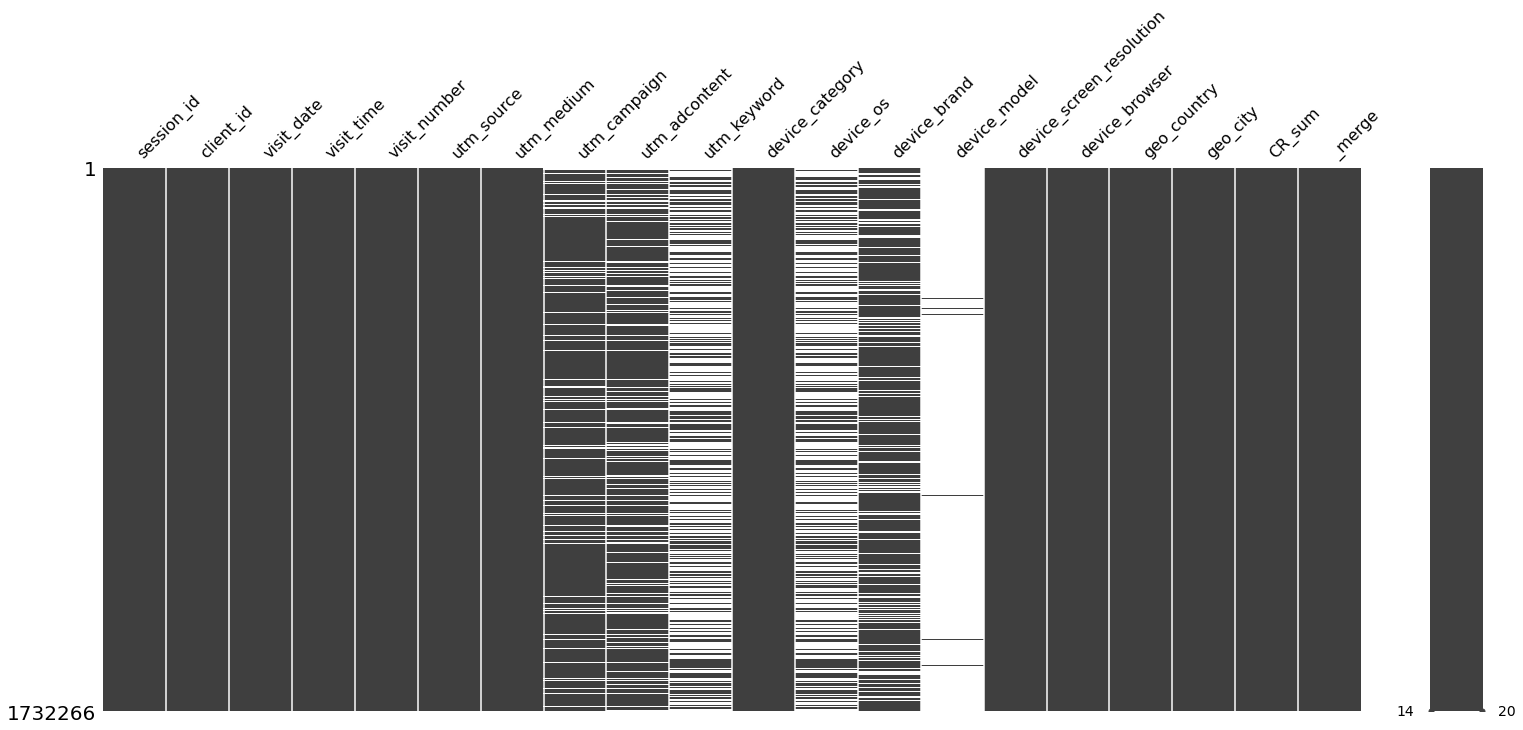

In [44]:
# Визуально посмотрим информацию в столбцах на предмет отсутствующих данных
msno.matrix(df_join_);

In [71]:
# Изучаем характеристики столбцов таблицы и их значений
df_info_uniq(df_join_)


Характеристика: session_id
Количество уникальных значений:  1732266
Список значений:  9055434745589932991.1637753792.1637753792    1
629529258169981545.1626332167.1626332167     1
6295352713792576176.1634065074.1634065074    1
6295350622136026841.1626588901.1626588901    1
6295349887709233242.1639202906.1639202906    1
                                            ..
3524000133754500026.1625142208.1625142208    1
3523993785803856201.1636161866.1636161866    1
352398731068897298.1621686290.1621686290     1
3523985479341028705.1640084833.1640084833    1
9055430416266113553.1640968742.1640968742    1
Name: session_id, Length: 1732266, dtype: int64

Характеристика: client_id
Количество уникальных значений:  1320702
Список значений:  1.750498e+09    449
1.266575e+09    303
7.368596e+08    301
1.894772e+09    270
1.065182e+09    256
               ... 
8.760138e+08      1
8.760135e+07      1
8.760101e+07      1
8.760069e+08      1
2.108382e+09      1
Name: client_id, Length: 1320702, dtype: i

Список значений:  Russia                 1682423
Ukraine                   8455
United States             8141
Belarus                   3432
Kazakhstan                2109
                        ...   
Paraguay                     1
New Caledonia                1
Puerto Rico                  1
Yemen                        1
Congo - Brazzaville          1
Name: geo_country, Length: 159, dtype: int64

Характеристика: geo_city
Количество уникальных значений:  2389
Список значений:  Moscow              750928
Saint Petersburg    278402
(not set)            73297
Yekaterinburg        33555
Krasnodar            30260
                     ...  
Oldbury                  1
Bad Breisig              1
Ilza                     1
Svishtov                 1
Compiegne                1
Name: geo_city, Length: 2389, dtype: int64

Характеристика: CR_sum
Количество уникальных значений:  52
Список значений:  0      1681952
1        27273
3        11232
2         6955
4         2520
6          809
5     

#### 1.3.2.   Работа с отсутствующими  и нулевыми данными 

In [209]:
missing_values(df_join_)

Процент пропущенных значений:


device_model                99.130503
utm_keyword                 58.925823
device_os                   58.533966
device_brand                20.042880
utm_adcontent               17.557177
utm_campaign                11.273500
utm_source                   0.004387
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
CR_sum                       0.000000
dtype: float64

- 13 колонок из 20 заполнены на 100%
- 7 колонок не заполнены полностью (от 0,5 до 99%)
- колонка 'device_model' почти не заполнена (99,1% данных отсутствуют) - подлежит удалению
- колонка '_merge' - вспомогательная, можно удалить
- 'utm_keyword' (59% данных отсутствуют), 'device_os'(59% данных отсутствуют) - много отсутствующих данных, можно удалить

##### 1.3.2.1. Удаление колонок с отсутствующими данными более 20% --- 'device_model','_merge', 'utm_keyword', 'device_os'

In [31]:
# Удаляем 3 колонок, общее количество колонок в таблице остается 16, сохраняем таблицу
df_clean = df_join_.drop(columns=['device_model','utm_keyword', 'device_os'])
print(df_clean.shape)

(1732266, 16)


In [32]:
df_clean.to_csv('data/df_clean.csv', index=False)

##### 1.3.2.2.  Проверка объема нулевых значений по столбцам таблицы (='(not set)' или 'none')

In [210]:
check_none_values (df_clean)

Проверка % нулевых значений объектов из всей выборки (проверка нулевых данных): 


,columns,result
6,utm_medium,16.017459
14,geo_city,4.231279
10,device_brand,0.946275
13,geo_country,0.061827
12,device_browser,0.000635
0,session_id,0.000000
1,client_id,0.000000
2,visit_date,0.000000
3,visit_time,0.000000
4,visit_number,0.000000


Из 16 столбцов в 5 наблюдаются нулевые значения

Как видно, наибольшее количество нулевые значений в столбцах 'utm_medium' и 'geo_city', и они нужны для работы 

In [86]:
df_clean = pd.read_csv('data/df_clean.csv')

##### 1.3.2.3. Работа со столбцами с отсутствующими и нулевыми значениями (8 столбцов)
'utm_source', 'utm_campaign', 'utm_adcontent', 'device_brand', 'utm_medium', 'device_browser', 'geo_country', 'geo_city',  
##### 'utm_source'  - замена на моды столбца, сформированные через группировку по столбцу 'utm_adcontent'
'utm_source' - канал привлечения, отсутствуют 0,004% данных, нулевых данных нет

In [87]:
df_clean['utm_source'] = re_moda_group(df_clean, 'utm_adcontent', 'utm_source')

Итоговый процент отсутствующих значений после замены:  0.0020782027702442927


In [88]:
# Количество пустых 'utm_source' уменьшилось, но не обнулилось. Заменим оставшиеся на моду всего столбца
df_clean['utm_source'] = replace_isna_data_all_column_mode(df_clean['utm_source'])

Итоговый процент отсутствующих значений после замены на моду столбца -  0


In [89]:
df_join_[df_join_['utm_source']=='ZpYIoDJMcFzVoPFsHGJL'].shape

(552555, 19)

In [90]:
df_clean[df_clean['utm_source']=='ZpYIoDJMcFzVoPFsHGJL'].shape

(552631, 16)

#####  'utm_campaign'  --- замена на моды столбца через группировку по столбцу 'utm_source'
'utm_campaign' - рекламная кампания, отсутствуют 11,2% данных, нулевых значений нет

In [81]:
# Проверяем целесообразность группировки по столбцам, выбираем для группировки столбец 'utm_source'
df1 = df_clean.query('utm_campaign=="LTuZkdKfxRGVceoWkVyg"')
print('Количество уникальных значений: ', df1['utm_source'].nunique())
print('Список значений: ',  df1['utm_source'].value_counts())

Количество уникальных значений:  210
Список значений:  ZpYIoDJMcFzVoPFsHGJL    197298
fDLlAcSmythWSCVMvqvL     98765
kjsLglQLzykiRbcDiGcD     87547
MvfHsxITijuriZxsqZqt     62735
BHcvLfOaCWvWTykYqHVe     39672
                         ...  
NmOxMbxOBZyJqqGcWBnH         1
SYQTbMrWPSQnOfTSlQxp         1
fcwjEERKGqQLIBYNygQV         1
mtQufDECJCXyKwpKQPvz         1
BellrslNBZQZaIxVFGXJ         1
Name: utm_source, Length: 210, dtype: int64


In [91]:
df_clean['utm_campaign'] = re_moda_group(df_clean, 'utm_source', 'utm_campaign')

Итоговый процент отсутствующих значений после замены:  0.002251386334431317


In [92]:
# Количество пустых 'utm_campaign' уменьшилось, но не обнулилось. Заменим оставшиеся на моду всего столбца
df_clean['utm_campaign'] = replace_isna_data_all_column_mode(df_clean['utm_campaign'])

Итоговый процент отсутствующих значений после замены на моду столбца -  0


In [95]:
df_join_[df_join_['utm_campaign']=='LTuZkdKfxRGVceoWkVyg'].shape

(422992, 19)

In [96]:
df_clean[df_clean['utm_campaign']=='LTuZkdKfxRGVceoWkVyg'].shape

(618120, 16)

#####  'utm_adcontent' --- замена на моды столбца через группировку по столбцу 'utm_source'
'utm_adcontent' - марка устройства, отсутствуют 17,6% данных, нулевых данных нет

In [90]:
# Проверяем целесообразность группировки по столбцам, выбираем 'utm_source'
df2 = df_clean.query('utm_adcontent=="vCIpmpaGBnIQhyYNkXqp"')
print('Количество уникальных значений: ', df2['utm_source'].nunique())
print('Список значений: ',  df2['utm_source'].value_counts())

Количество уникальных значений:  2
Список значений:  ZpYIoDJMcFzVoPFsHGJL    179151
bByPQxmDaMXgpHeypKSM       287
Name: utm_source, dtype: int64


In [97]:
# Заменим отсутствующие значения на моды столбца, сформированные через группировку по столбцу 'utm_source'
df_clean['utm_adcontent'] = re_moda_group(df_clean, 'utm_source', 'utm_adcontent')

Итоговый процент отсутствующих значений после замены:  0.001270012804038179


In [98]:
# Количество пустых 'utm_adcontent'' уменьшилось, но не обнулилось. Заменим оставшиеся на моду всего столбца
df_clean['utm_adcontent'] = replace_isna_data_all_column_mode(df_clean['utm_adcontent'])

Итоговый процент отсутствующих значений после замены на моду столбца -  0


In [99]:
df_join_[df_join_['utm_adcontent']=='vCIpmpaGBnIQhyYNkXqp'].shape

(179438, 19)

In [100]:
df_clean[df_clean['utm_adcontent']=='vCIpmpaGBnIQhyYNkXqp'].shape

(179443, 16)

#####  'device_brand' --- замена на моды столбца 
'device_brand' - марка устройства, отсутствуют 20% данных, нулевых 0,95% данных

In [105]:
# Проверяем целесообразность группировки по столбцам, выбираем 'device_category'
df3= df_clean.query('device_brand=="Apple"')
print('Количество уникальных значений: ', df3['device_category'].nunique())
print('Список значений: ',  df3['device_category'].value_counts())

Количество уникальных значений:  3
Список значений:  mobile     398382
desktop    100779
tablet       4816
Name: device_category, dtype: int64


In [106]:
# Так как Apple подавляющий бренд, заменим на моду всего столбца
df_clean['device_brand'] = replace_isna_data_all_column_mode(df_clean['device_brand'])

Итоговый процент отсутствующих значений после замены на моду столбца -  0


In [102]:
df_join_[df_join_['device_brand']=='Apple'].shape

(503533, 19)

In [107]:
df_clean[df_clean['device_brand']=='Apple'].shape

(850729, 16)

In [108]:
# Так как нулевых значений мало, заменим их на единую моду столбца и проверим результат
df_clean['device_brand'] = replace_none_data_all_column_mode(df_clean['device_brand'])
none_value (df_clean['device_brand'] )

Процент нулевых значений:  0.0


##### 'utm_medium' --- замена на моды столбца через группировку по столбцу 'utm_source' и "other"
'utm_medium' - тип привлечения, нулевые 16% данных, отсутствующих данных нет

In [109]:
df_clean['utm_medium'] = re_moda_group_none(df_clean, 'utm_source', 'utm_medium', 'other')

Процент нулевых значений:  0.0


In [110]:
df_clean['utm_medium'].unique()

array(['banner', 'cpm', 'cpc', 'organic', 'referral', 'smm', 'stories',
       'blogger_channel', 'blogger_stories', 'email', 'app', 'push',
       'partner', 'tg', 'cpv', 'cpa', 'post', 'smartbanner', 'info_text',
       'outlook', 'clicks', 'landing', 'blogger_header', 'qr',
       'google_cpc', 'sms', 'article', 'vk_smm', 'static', 'cbaafe',
       'Sbol_catalog', 'fb_smm', 'landing_interests', 'yandex_cpc',
       'web_polka', 'link', 'CPM', 'linktest', 'qrcodevideo', 'users_msk',
       'dom_click', 'ok_smm', 'sber_app', 'promo_sber', 'reach', 'nkp',
       'medium', 'tablet', 'promo_sbol', 'social', 'main_polka',
       'catalogue', 'last', 'other'], dtype=object)

#####  'device_browser' --- замена нулевых на моду столбца
'device_browser' - браузер, нулевых 0.0006% данных, отсутствующих данных нет, 

In [111]:
# Очень мало нулевых значений, поэтому применяем замену на моду столбца
df_clean['device_browser']  = replace_none_data_all_column_mode(df_clean['device_browser'])
none_value(df_clean['device_browser'])

Процент нулевых значений:  0.0


#####  'geo_country' --- замена нулевые значения на моду столбца
'geo_country' - страна, нулевых 0,06% данных, отсутствующих данных нет 

In [112]:
# Очень мало нулевых значений, поэтому применяем замену на моду столбца
df_clean['geo_country']  = replace_none_data_all_column_mode(df_clean['geo_country'])
none_value(df_clean['geo_country'])

Процент нулевых значений:  0.0


#####  'geo_city'--- замена нулевые значения на моду столбца сформированные через группировку по столбцу 'geo_country'
'geo_city' - город, нулевых 4,2% данных, отсутствующих данных нет, столбец группировки по смыслу - 'geo_country'

In [113]:
df_clean['geo_city'] = re_moda_group_none(df_clean, 'geo_country', 'geo_city', "Capital")

Процент нулевых значений:  0.0


In [114]:
# Есть ячейки, которые содержат только числа, а не названия городов, надо их выбрать, выделяем, заменяем на моду столбца
# Проверяем наличие только числовых значений к текстовой ячейке столбца таблицы
numer(df_clean.geo_city)
df_clean['geo_city'] = ['Capital' if x.isdigit() == True   else x for  x in df_clean['geo_city']]

Числовых значений -  289


In [115]:
numer(df_clean.geo_city)

Числовых значений нет


In [116]:
# Учитывая незначительность числовых значений - оставим их в таблице, т.к. на итоговые результаты они значительного 
# влияния не окажут. Были ячейки c ошибочными непонятными символами (ошибки), проверим их наличие
missing_values_ = ((len(df_clean[((df_clean['geo_city']=='РҐРѕРјСѓС‚РѕРІРѕ') | (df_clean['geo_city']=='РўРёРјРѕС„РµРµРІРєР°') | (df_clean['geo_city']=='РўР°СЂР°СЃРѕРІРєР°'))])/len(df_clean))*100)
missing_values_

0.0

##### 1.3.2.4.  Проверка результатов работы с таблицей

In [118]:
# Проверяем итоговое заполнение таблицы и наличие нулевых значений
print_useful_rows_info(df_clean)

Количество полностью заполненных объектов из всей выборки:  1732266
Процент полностью заполненных объектов из всей выборки:  100.0


In [119]:
check_none_values (df_clean)

Проверка % нулевых значений объектов из всей выборки (проверка нулевых данных): 


,columns,result
0,session_id,0.0
1,client_id,0.0
2,visit_date,0.0
3,visit_time,0.0
4,visit_number,0.0
5,utm_source,0.0
6,utm_medium,0.0
7,utm_campaign,0.0
8,utm_adcontent,0.0
9,device_category,0.0


#### 1.3.3.  Преобразование типов данных
##### 1.3.3.1.  Преобразование столбцов даты и времени визита 
объединим и приведем тип данных в соответствие

In [120]:
df_clean_res = df_clean

In [121]:
df_clean_res['visit_date'] = df_clean_res['visit_date'] +" "+ df_clean_res['visit_time'] 
df_clean_res['visit_date'] = pd.to_datetime(df_clean_res.visit_date, utc=True)
# Проверим выбросы в годе визита. Не установлено
df_clean_res['year_visit'] = df_clean_res['visit_date'].dt.year
df_clean_res.year_visit.describe()

count    1732266.0
mean        2021.0
std            0.0
min         2021.0
25%         2021.0
50%         2021.0
75%         2021.0
max         2021.0
Name: year_visit, dtype: float64

Весь временной период укладывается в 2021 год - май --- декабрь

#### 1.3.4. Удаление "лишних" столбцов

In [117]:
print(df_clean.columns)

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'CR_sum'],
      dtype='object')


In [123]:
df_clean_res = df_clean_res.drop(columns=['visit_time','year_visit'])
print(df_clean_res.shape)

(1732266, 15)


## 2. FEATURE ENGINEERING

### 2.1. Формирование дополнительных, необходимых для анализа, столбцов
#### 2.1.1. Формирование столбца  'CR_result'  (0/1), 'org_traffic', 'advertising_social_NW,  'city_of_presence'
##### Формирование столбца  'CR_result'  (0/1) 
На базе 'CR_sum' сформируем новый столбец 'CR_result' с признаками 0/1. 'CR_result' = 1, если 'CR_sum' >=1

In [124]:
df_clean_res['CR_result'] = [1 if x >= 1
    else 0 for x in df_clean_res['CR_sum']]
print(df_clean_res.shape)
print('Список значений: ',  df_clean_res['CR_result'].value_counts())

(1732266, 16)
Список значений:  0    1681952
1      50314
Name: CR_result, dtype: int64


#####  'org_traffic' - информация по органическому трафику
Для исследования необходима информация по органическому трафику. Создаем столбец 'org_traffic'

In [125]:
df_clean_res['org_traffic'] = ['органический трафик' if (x == 'organic' or x =='referral' or x =='none')
    else 'платный трафик' for x in df_clean_res['utm_medium']]
print(df_clean_res.shape)
print('Количество уникальных значений: ', df_clean_res['org_traffic'].nunique())
print('Список значений: ',  df_clean_res['org_traffic'].value_counts())

(1732266, 17)
Количество уникальных значений:  2
Список значений:  платный трафик         1540396
органический трафик     191870
Name: org_traffic, dtype: int64


#####  'advertising_social_NW - информация по рекламе в социальных сетях
Для исследования необходима информация по рекламе в социальных сетях. Создаем столбец 'advertising_social_NW

In [126]:
df_clean_res['advertising_social_NW'] = ['реклама в соц.сетях' if (x == 'QxAxdyPLuQMEcrdZWdWb' or x =='MvfHsxITijuriZxsqZqt' 
    or x =='ISrKoXQCxqqYvAZICvjs' or x =='IZEXUFLARCUMynmHNBGo' or x =='PlbkrSYoHuZBWfYjYnfw' or x =='gVRrcxiDQubJiljoTbGm')
    else 'иная реклама' for x in df_clean_res['utm_source']]
print(df_clean_res.shape)
print('Количество уникальных значений: ', df_clean_res['advertising_social_NW'].nunique())
print('Список значений: ',  df_clean_res['advertising_social_NW'].value_counts())

(1732266, 18)
Количество уникальных значений:  2
Список значений:  иная реклама           1475986
реклама в соц.сетях     256280
Name: advertising_social_NW, dtype: int64


#####  'city_of_presence' - информация по городам присутствия
Для исследования необходима информация по городам присутствия. Создаем столбец 'city_of_presence'

In [127]:
df_clean_res['city_of_presence'] = ['Москва+Санкт-П' if (x == 'Moscow' or x =='Saint Petersburg')
    else 'другие города' for x in df_clean_res['geo_city']]
df_info_(df_clean_res)

Размер выборки - (1732266, 19)
Состав выборки - Index(['session_id', 'client_id', 'visit_date', 'visit_number', 'utm_source',
       'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category',
       'device_brand', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'CR_sum', 'CR_result', 'org_traffic',
       'advertising_social_NW', 'city_of_presence'],
      dtype='object')


,session_id,client_id,visit_date,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,CR_sum,CR_result,org_traffic,advertising_social_NW,city_of_presence
0,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24 14:36:32+00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0,0,платный трафик,иная реклама,другие города
1,905544597018549464.1636867290.1636867290,2.108385e+08,2021-11-14 08:21:30+00:00,1,ZpYIoDJMcFzVoPFsHGJL,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0,0,платный трафик,иная реклама,Москва+Санкт-П
2,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28 02:42:06+00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0,0,платный трафик,иная реклама,другие города


In [128]:
df_clean_res.to_csv('data/df_clean_res', index=False)

In [129]:
df = pd.read_csv('data/df_clean_res')

###### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [130]:
df_info_uniq(df)


Характеристика: session_id
Количество уникальных значений:  1732266
Список значений:  9055434745589932991.1637753792.1637753792    1
629529258169981545.1626332167.1626332167     1
6295352713792576176.1634065074.1634065074    1
6295350622136026841.1626588901.1626588901    1
6295349887709233242.1639202906.1639202906    1
                                            ..
3524000133754500026.1625142208.1625142208    1
3523993785803856201.1636161866.1636161866    1
352398731068897298.1621686290.1621686290     1
3523985479341028705.1640084833.1640084833    1
9055430416266113553.1640968742.1640968742    1
Name: session_id, Length: 1732266, dtype: int64

Характеристика: client_id
Количество уникальных значений:  1320701
Список значений:  1.750498e+09    449
1.266575e+09    303
7.368596e+08    301
1.894772e+09    270
1.065182e+09    256
               ... 
8.760135e+07      1
8.760101e+07      1
8.760069e+08      1
8.760060e+07      1
2.108382e+09      1
Name: client_id, Length: 1320701, dtype: i

Список значений:  Moscow               817754
Saint Petersburg     278402
Yekaterinburg         33555
Krasnodar             30260
Kazan                 27689
                      ...  
Palermo                   1
Busto Arsizio             1
Casale Monferrato         1
Como                      1
Brazzaville               1
Name: geo_city, Length: 2362, dtype: int64

Характеристика: CR_sum
Количество уникальных значений:  52
Список значений:  0      1681952
1        27273
3        11232
2         6955
4         2520
6          809
5          809
7          210
8          117
9          104
10          73
12          29
11          22
14          19
18          17
13          13
16          10
24           8
22           8
17           7
21           7
35           6
23           6
20           6
19           6
27           5
25           5
15           4
39           3
30           3
28           3
38           2
26           2
42           2
33           2
67           1
474          

#### 2.1.2. Преобразование 'client_id', 'date', добавление столбцов дат 'month' и 'dayofweek'

In [131]:
# Преобразовываем тип столбца в целочисленное
df['client_id'] = df['client_id'].astype(int)

# Преобразовываем дату, создаем столбцы месяца и дня недели. По времени - не будем, т.к. много временных поясов
df['date'] = pd.to_datetime(df['visit_date'], errors='coerce')
df['month'] = df.date.dt.month
df['dayofweek'] = df.date.dt.dayofweek

#### 2.1.3. Преобразование категориальных - 'device_screen_resolution', 'device_browser', 'device_brand', 'utm_campaign',  'utm_source', 'geo_city' 
Целью преобразования является сокращение категорий данных. Берем основные используемые из списков уникальных категорий, приведенного выше. Лидеры количества обычно являются и лидерами конверсии.

Проверим на примере лидеров распределения среди рекламных кампаний

(406, 3)
Лидеры среди рекламных кампаний


<Figure size 432x288 with 0 Axes>

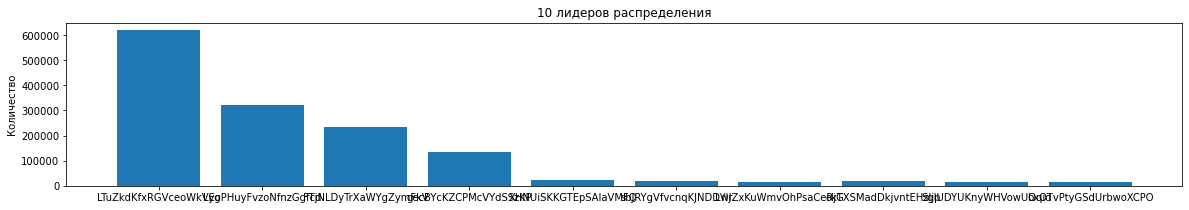

<Figure size 432x288 with 0 Axes>

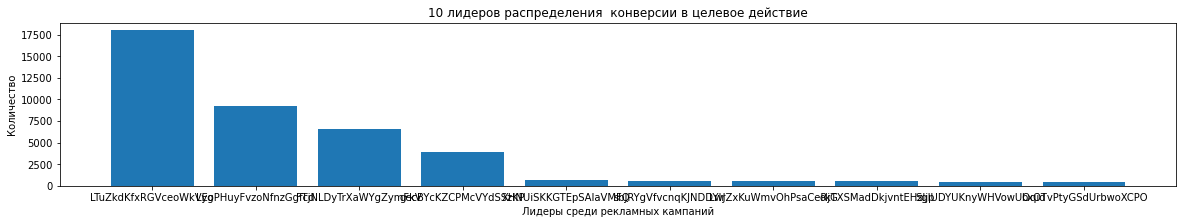

In [132]:
stats_utm_campaign = gr_CR_and_count(df, 'utm_campaign')
print(stats_utm_campaign.shape)
vis_leaders_count_CR(stats_utm_campaign, 'utm_campaign', 'Лидеры среди рекламных кампаний')

Кампании лидеры конверсии совпадают с лидерами визитов, поэтому берем лидеров количества 

In [133]:
# Добавляем категориальную переменную разрешения экрана- device_screen_resolution -- 4947 значений - по кол-ву знаков в разрешении (7 == малое, >7 == большое)
df['device_screen'] = ['большое разрешение' if len(i)>7 else 'малое разрешение' for  i in df['device_screen_resolution']]

# Добавляем категориальную переменную    device_browser --- 54 значения - - выделяем основные браузеры, 
# Chrome 1, Safari - 2, YaBrowser - 3, остальные - 4
df['device_browser_'] = np.where(((df['device_browser']!='Chrome') & (df['device_browser']!='Safari') & (df['device_browser']!='YaBrowser')), 'other_browser', df['device_browser'])

# Добавляем категориальную переменную    device_brand --- 199 значений - выделяем основные бренды, 
# Apple - 1, Samsung - 2, Xiaomi - 3, Huawei - 4, остальные - 5
df['device_brand_'] = np.where(((df['device_brand']!='Apple') & (df['device_brand']!='Samsung') & (df['device_brand']!='Xiaomi') & (df['device_brand']!='Huawei')), 'other_bran', df['device_brand'])

# Добавляем категориальную переменную    utm_campaign_ --- 487 значения - - выделяем основные кампании, 
df['utm_campaign_'] = np.where(((df['utm_campaign']!='LTuZkdKfxRGVceoWkVyg') & 
                                (df['utm_campaign']!='LEoPHuyFvzoNfnzGgfcd') & (df['utm_campaign']!='FTjNLDyTrXaWYgZymFkV') &
                                (df['utm_campaign']!='gecBYcKZCPMcVYdSSzKP')), 'other_campaign', df['utm_campaign'])

# Добавляем категориальную переменную    utm_source_ --- 280 значения - - выделяем основные каналы, 
df['utm_source_'] = np.where(((df['utm_source']!='ZpYIoDJMcFzVoPFsHGJL') & 
                                (df['utm_source']!='fDLlAcSmythWSCVMvqvL') & (df['utm_source']!='kjsLglQLzykiRbcDiGcD') &
                                (df['utm_source']!='bByPQxmDaMXgpHeypKSM') & (df['utm_source']!='BHcvLfOaCWvWTykYqHVe')), 'other_source', df['utm_source'])

# Добавляем категориальную переменную    geo_city_ --- 2365 значения - - выделяем основные города (большие города миллионники), 
df['geo_city_'] = np.where(((df['geo_city']!='Moscow') & (df['geo_city']!='Saint Petersburg') & (df['geo_city']!='Nizhny Novgorod') &
                            (df['geo_city']!='Yekaterinburg') & (df['geo_city']!='Krasnodar') & (df['geo_city']!='Ufa') &
                            (df['geo_city']!='Kazan') & (df['geo_city']!='Samara') & (df['geo_city']!='Novosibirsk') &
                            (df['geo_city']!='Krasnoyarsk')), 'other_city', df['geo_city'])

Проверим результаты и посмотрим структуру получившихся категориальных значений:

In [134]:
print('Список значений:\n',  df['device_screen'].value_counts())

Список значений:
 малое разрешение      1373517
большое разрешение     358749
Name: device_screen, dtype: int64


In [135]:
print('Список значений:\n',  df['device_browser_'].value_counts())

Список значений:
 Chrome           951584
Safari           436705
other_browser    220212
YaBrowser        123765
Name: device_browser_, dtype: int64


In [136]:
print('Список значений:\n',  df['device_brand_'].value_counts())

Список значений:
 Apple         867121
Samsung       311641
Xiaomi        269251
Huawei        173828
other_bran    110425
Name: device_brand_, dtype: int64


In [137]:
print('Список значений:\n',  df['utm_campaign_'].value_counts())

Список значений:
 LTuZkdKfxRGVceoWkVyg    618120
other_campaign          424512
LEoPHuyFvzoNfnzGgfcd    321404
FTjNLDyTrXaWYgZymFkV    234976
gecBYcKZCPMcVYdSSzKP    133254
Name: utm_campaign_, dtype: int64


In [138]:
print('Список значений:\n',  df['utm_source_'].value_counts())

Список значений:
 ZpYIoDJMcFzVoPFsHGJL    552631
other_source            456078
fDLlAcSmythWSCVMvqvL    277060
kjsLglQLzykiRbcDiGcD    245178
BHcvLfOaCWvWTykYqHVe    110963
bByPQxmDaMXgpHeypKSM     90356
Name: utm_source_, dtype: int64


In [139]:
print('Список значений:\n',  df['geo_city_'].value_counts())

Список значений:
 Moscow              817754
other_city          444710
Saint Petersburg    278402
Yekaterinburg        33555
Krasnodar            30260
Kazan                27689
Samara               23433
Nizhny Novgorod      20782
Ufa                  20283
Novosibirsk          20115
Krasnoyarsk          15283
Name: geo_city_, dtype: int64


geo_country: Количество уникальных значений:  158     Список значений:  Russia           1683494   - 95%

utm_adcontent: Количество уникальных значений:  281   Список значений:  JNHcPlZPxEMWDnRiyoBf    1234204   90%

поэтому не будем делать моделирование на эти признаки

####  Исследование 'model_auto_sum'

In [ ]:
Все модели авто ---
array(['skoda rapid', 'lada-vaz vesta', 'volkswagen polo', 'skoda karoq',
       'mercedes-benz e-klasse', 'nissan qashqai', 'nissan', 'kia rio',
       'nissan x-trail', 'skoda octavia', 'renault duster',
       'toyota camry', 'renault logan', 'kia seltos', 'kia sorento',
       'volkswagen tiguan', 'mercedes-benz glb',
       'mercedes-benz gla-klasse', 'volvo s90', 'haval jolion',
       'bmw 5-serii', 'mercedes-benz g-klasse', 'porsche cayenne',
       'mini hatch', 'bmw 3-serii', 'bmw x5', 'skoda kodiaq',
       'mercedes-benz gle', 'bmw x3', 'mercedes-benz glc',
       'mercedes-benz c-klasse', 'peugeot traveller',
       'toyota land-cruiser-prado', 'land-rover range-rover',
       'toyota corolla', 'bmw 2-serii', 'mercedes-benz s-klasse',
       'porsche 911', 'toyota fortuner', 'bmw x6', 'hyundai solaris',
       'mercedes-benz gls-klasse', 'volkswagen touareg', 'audi e-tron',
       'audi a3', 'toyota alphard', 'volkswagen teramont', 'audi q5',
       'audi a4', 'bmw 7-serii', 'mercedes-benz cla-klasse', 'bmw x7',
       'volkswagen taos', 'kia', 'bmw', 'toyota', 'porsche panamera',
       'mercedes-benz', 'audi', 'skoda', 'kia cerato', 'volkswagen',
       'renault arkana', 'hyundai', 'https:', 'renault', 'chevrolet',
       'toyota rav-4', 'kia sportage', 'honda civic-type-r', 'haval',
       'mitsubishi', 'mazda', 'ford', 'lexus', 'honda', 'land-rover',
       'land-rover range-rover-velar', 'gaz', 'volkswagen passat-cc',
       'porsche macan', 'infiniti qx60', 'volvo', 'alfa-romeo', 'bmw x1',
       'porsche', 'chery', 'acura', 'bentley', 'volkswagen passat',
       'land-rover defender', 'dodge', 'daewoo', 'peugeot', 'uaz', 'jeep',
       'genesis', 'mini', 'asia', 'geely', 'lada_(vaz)', 'cheryexeed',
       'changan', 'fiat', 'opel', 'iran-khodro', 'lamborghini', 'h6',
       'byd', 'subaru', 'kia k5', 'suzuki', 'buick', 'tesla', 'lifan',
       'citroen', 'jaguar', 'mercedes-benz v-klasse', 'gac', 'datsun',
       'e994838', 'zaz', 'great-wall', 'mercedes-benz cls-klasse',
       'hummer', 'vortex', 'faw', 'rover', 'smart', 'jac', 'audi a5',
       'scion', 'qashqai', 'brilliance', 'foton', 'hawtai', 'granta',
       'es', 'lincoln', 'ravon', 'haima', 'rolls-royce', 'dacia', 'saab',
       'seat', 'ssangyong'], dtype=object)

Оставим столбцы с марками авто на третью итерацию моделирования. Первые проведем без них

#### 2.1.4. Выводы по разделу 2.1.
- Целевая переменная ---  CR_result
- Поля для моделирования - session_id (id), client_id , month, dayofweek, visit_number, device_screen (кат), device_browser_, device_category (кат), device_brand_(кат),  utm_medium(кат), utm_campaign_(кат), utm_source_(кат), geo_city(кат), city_of_presence (кат), advertising_social_NW (кат), org_traffic (кат)

- Столбцы на удаление --  geo_country, device_brand, device_browser, device_screen_resolution, visit_date, utm_adcontent, utm_campaign, utm_source, geo_city

### 2.2. Исследование распределения конверсии во времени

In [140]:
# Преобразуем дату, уберем время
df['date'] = pd.to_datetime(df['date']).dt.date
df.date[0:3]

0    2021-11-24
1    2021-11-14
2    2021-12-28
Name: date, dtype: object

Распределение конверсии в визит по дням периода


<Figure size 432x288 with 0 Axes>

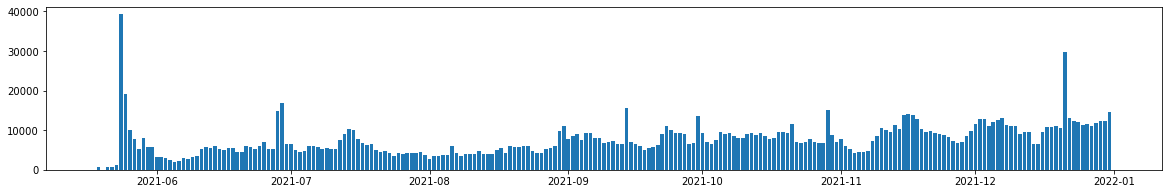

Распределение суммарной конверсии в действие по дням периода


<Figure size 432x288 with 0 Axes>

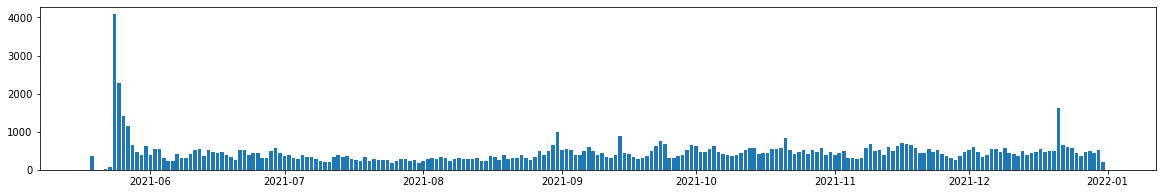

Распределение результирующей конверсии в действие по дням периода


<Figure size 432x288 with 0 Axes>

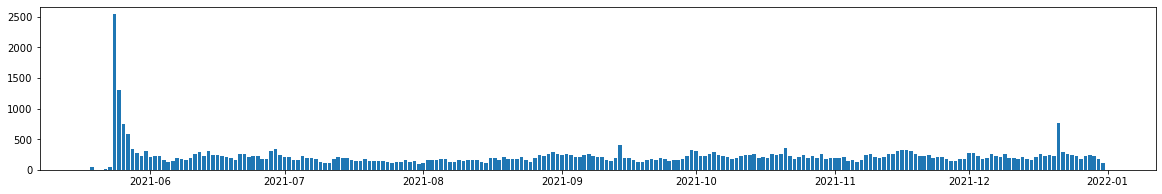

In [141]:
d = df.groupby(['date']).agg({'session_id': 'size', 'CR_sum': 'sum', 'CR_result': 'sum'}).reset_index().rename(columns={'session_id': 'count', 'CR_result': 'count_CR'}).sort_values(by='date', ascending = True)
# Построим графики распределения во времени
plt.figure(1)
print('Распределение конверсии в визит по дням периода')
plt.figure(figsize=(20, 3))
plt.bar(d['date'], d['count'])
plt.show();
plt.figure(2)
print('Распределение суммарной конверсии в действие по дням периода')
plt.figure(figsize=(20, 3))
plt.bar(d['date'], d['CR_sum'])
plt.show();
plt.figure(3)
print('Распределение результирующей конверсии в действие по дням периода')
plt.figure(figsize=(20, 3))
plt.bar(d['date'], d['count_CR'])
plt.show();

Как видно из графиков пики конверсий по дням совпадают, особенно дни максимумов.

Рассмотрим распределение конверсий по месяцам

Распределение конверсии в визит по месяцам периода


<Figure size 432x288 with 0 Axes>

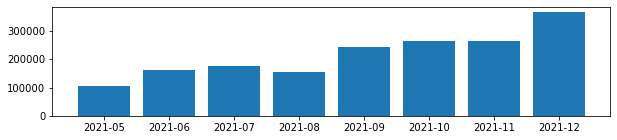

Распределение сумимарной конверсии в действие по месяцам периода


<Figure size 432x288 with 0 Axes>

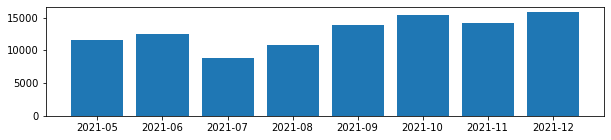

Распределение результирующей конверсии в действие по месяцам периода


<Figure size 432x288 with 0 Axes>

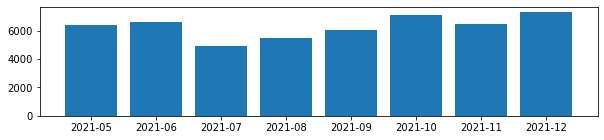

In [142]:
d['date_mon'] = [ i.strftime("%Y-%m") for i in d['date']]
d_ = d.groupby(['date_mon']).agg({'count': 'sum', 'CR_sum': 'sum', 'count_CR': 'sum'}).reset_index().sort_values(by='date_mon', ascending = True)
plt.figure(1)
print('Распределение конверсии в визит по месяцам периода')
plt.figure(figsize=(10, 2))
plt.bar(d_['date_mon'], d_['count'])
plt.show();
plt.figure(2)
print('Распределение сумимарной конверсии в действие по месяцам периода')
plt.figure(figsize=(10, 2))
plt.bar(d_['date_mon'], d_['CR_sum'])
plt.show();
plt.figure(3)
print('Распределение результирующей конверсии в действие по месяцам периода')
plt.figure(figsize=(10, 2))
plt.bar(d_['date_mon'], d_['count_CR'])
plt.show();

Как видно из графиков по месяцам конверсии имеют одинаковый тренд - рост к концу периода, но по месяцам графики различаются. Одинаковую форму имеют графики суммарной и результирующей конверсии, поэтому далее можно рассматривать один из признаков. ---- Оставим результирующую конверсию - 'CR_result'.

In [143]:
df.columns

Index(['session_id', 'client_id', 'visit_date', 'visit_number', 'utm_source',
       'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category',
       'device_brand', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'CR_sum', 'CR_result', 'org_traffic',
       'advertising_social_NW', 'city_of_presence', 'date', 'month',
       'dayofweek', 'device_screen', 'device_browser_', 'device_brand_',
       'utm_campaign_', 'utm_source_', 'geo_city_'],
      dtype='object')

In [144]:
# Удалим дублирующие и лишние столбцы
df_ = df1 = df.drop(columns=['CR_sum', 'geo_country', 'device_brand', 'device_browser', 'device_screen_resolution', 
                             'visit_date', 'utm_adcontent', 'utm_campaign', 'utm_source', 'geo_city'])
df_.shape
df_.head(3)

,session_id,client_id,visit_number,utm_medium,device_category,CR_result,org_traffic,advertising_social_NW,city_of_presence,date,month,dayofweek,device_screen,device_browser_,device_brand_,utm_campaign_,utm_source_,geo_city_
0,9055434745589932991.1637753792.1637753792,2108382700,1,banner,mobile,0,платный трафик,иная реклама,другие города,2021-11-24,11,2,малое разрешение,Chrome,Huawei,LEoPHuyFvzoNfnzGgfcd,ZpYIoDJMcFzVoPFsHGJL,other_city
1,905544597018549464.1636867290.1636867290,210838531,1,cpm,mobile,0,платный трафик,иная реклама,Москва+Санкт-П,2021-11-14,11,6,малое разрешение,other_browser,Samsung,FTjNLDyTrXaWYgZymFkV,ZpYIoDJMcFzVoPFsHGJL,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331,1,banner,mobile,0,платный трафик,иная реклама,другие города,2021-12-28,12,1,малое разрешение,Chrome,Huawei,LEoPHuyFvzoNfnzGgfcd,ZpYIoDJMcFzVoPFsHGJL,Krasnoyarsk


In [145]:
# Сохраним промежуточную выборку, после EDA, полная, без моделей авто, перед исследованием корреляции и стандартизацией данных
df_.to_csv('data/df_fe1.csv', index=False)

In [146]:
df = pd.read_csv('data/df_fe1.csv')

### 2.3. Исследование корреляции признаков

In [147]:
df_ = df.apply(lambda x: pd.factorize (x)[0])
df_.corr()

,session_id,client_id,visit_number,utm_medium,device_category,CR_result,org_traffic,advertising_social_NW,city_of_presence,date,month,dayofweek,device_screen,device_browser_,device_brand_,utm_campaign_,utm_source_,geo_city_
session_id,1.000000,1.000000,0.010216,0.003054,0.001229,0.001104,0.000693,-0.040557,-0.063979,-0.000102,0.001747,0.000379,0.001230,-0.000713,0.230656,-0.000047,0.088790,-0.040689
client_id,1.000000,1.000000,0.010213,0.003055,0.001232,0.001104,0.000694,-0.040521,-0.063965,-0.000102,0.001747,0.000379,0.001233,-0.000714,0.230632,-0.000046,0.088979,-0.040680
visit_number,0.010216,0.010213,1.000000,0.001179,0.138107,0.027026,-0.000927,-0.007855,0.001517,0.011041,-0.002393,0.001021,0.136062,-0.007559,0.002538,0.001599,0.000183,0.001752
utm_medium,0.003054,0.003055,0.001179,1.000000,-0.000601,-0.000126,0.253436,0.000493,-0.000502,-0.000412,-0.001652,-0.000437,-0.000778,-0.000101,0.000310,0.391600,-0.000522,0.000520
device_category,0.001229,0.001232,0.138107,-0.000601,1.000000,0.012060,0.000403,-0.002141,-0.000459,0.025637,0.030054,0.029788,0.966566,0.001826,-0.000281,-0.000712,0.001275,0.000377
CR_result,0.001104,0.001104,0.027026,-0.000126,0.012060,1.000000,-0.000295,0.000274,0.000049,0.007648,0.006999,-0.001565,0.010867,0.006908,0.000411,0.002233,0.000650,0.000510
org_traffic,0.000693,0.000694,-0.000927,0.253436,0.000403,-0.000295,1.000000,-0.000649,0.000817,-0.000165,0.000681,0.001396,0.000041,-0.000096,-0.000949,0.083730,0.001681,0.000059
advertising_social_NW,-0.040557,-0.040521,-0.007855,0.000493,-0.002141,0.000274,-0.000649,1.000000,0.014913,0.000064,-0.001466,-0.001876,-0.001950,-0.001340,0.056215,0.000454,-0.013888,0.009727
city_of_presence,-0.063979,-0.063965,0.001517,-0.000502,-0.000459,0.000049,0.000817,0.014913,1.000000,0.001704,0.000299,-0.000290,-0.000073,0.000007,-0.024717,-0.000139,0.009200,-0.093495
date,-0.000102,-0.000102,0.011041,-0.000412,0.025637,0.007648,-0.000165,0.000064,0.001704,1.000000,0.178603,-0.001241,0.023775,0.019581,0.000275,-0.000501,-0.000558,-0.000712


<AxesSubplot:>

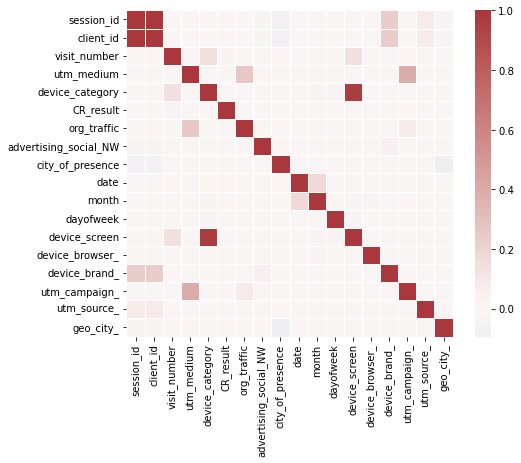

In [148]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_.corr(), cmap='vlag', center=0, square=True, linewidths=0.5)

Корреляция близкая к 1 между сессией и пользователем, один из столбцов нужно удалить, учитывая аналитику от сессии - удаляем user_id

Также близкая к 1 корреляция между категорией девайса и разрешением экрана, удалим разрешение экрана

In [149]:
df_ = df.drop(columns=['client_id', 'device_screen'])

<AxesSubplot:>

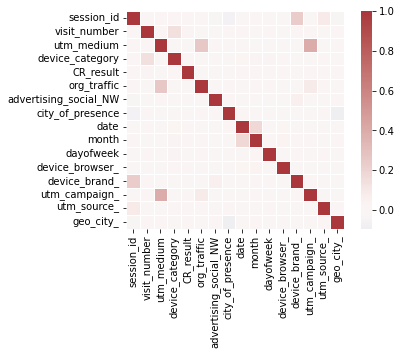

In [150]:
# Результирующая тепловая карта матрицы корреляций
df__ = df_.apply(lambda x: pd.factorize (x)[0])
sns.heatmap(df__.corr(), cmap='vlag', center=0, square=True, linewidths=0.5)

Оставим все оставшиеся переменные в выборке, т.к. корреляция признаков между собой менее 0,4

### 2.4. Стандартизация и нормализация данных

#### 2.4.1. Стандартизация категориальных переменных

In [151]:
data = df_[['device_browser_', 'device_category', 'device_brand_', 'utm_medium', 'utm_source_',
           'utm_campaign_', 'geo_city_', 'city_of_presence', 'advertising_social_NW', 'org_traffic']]

ohe_ = OneHotEncoder(sparse=False)
ohe_.fit(data)
ohe_data_ = ohe_.transform(data)
ohe_.get_feature_names_out(input_features=None)
df_[ohe_.get_feature_names_out()] = ohe_data_

df = df_.drop(columns=['device_browser_', 'device_category', 'device_brand_', 'utm_medium', 'utm_source_', 'utm_campaign_',
                       'geo_city_', 'city_of_presence', 'advertising_social_NW', 'org_traffic', 'date'])
df.shape

(1732266, 99)

#### 2.4.2. Стандартизация количественных переменных

In [152]:
data = df[['visit_number', 'month', 'dayofweek']]

std_scaler = StandardScaler()
std_scaler.fit(data)
std_scaled = std_scaler.transform(data)
df[['visit_number_std', 'month_std', 'dayofweek_std']] = std_scaled
df = df.drop(columns=['visit_number', 'month', 'dayofweek'])
df.head(2)

,session_id,CR_result,device_browser__Chrome,device_browser__Safari,device_browser__YaBrowser,device_browser__other_browser,device_category_desktop,device_category_mobile,device_category_tablet,device_brand__Apple,...,geo_city__other_city,city_of_presence_Москва+Санкт-П,city_of_presence_другие города,advertising_social_NW_иная реклама,advertising_social_NW_реклама в соц.сетях,org_traffic_органический трафик,org_traffic_платный трафик,visit_number_std,month_std,dayofweek_std
0,9055434745589932991.1637753792.1637753792,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.139817,0.778628,-0.399367
1,905544597018549464.1636867290.1636867290,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.139817,0.778628,1.613656


In [156]:
df_1 = df[['session_id', 'device_browser__Chrome',
       'device_browser__Safari', 'device_browser__YaBrowser',
       'device_browser__other_browser', 'device_category_desktop',
       'device_category_mobile', 'device_category_tablet',
       'device_brand__Apple', 'device_brand__Huawei', 'device_brand__Samsung',
       'device_brand__Xiaomi', 'device_brand__other_bran', 'utm_medium_CPM',
       'utm_medium_Sbol_catalog', 'utm_medium_app', 'utm_medium_article',
       'utm_medium_banner', 'utm_medium_blogger_channel',
       'utm_medium_blogger_header', 'utm_medium_blogger_stories',
       'utm_medium_catalogue', 'utm_medium_cbaafe', 'utm_medium_clicks',
       'utm_medium_cpa', 'utm_medium_cpc', 'utm_medium_cpm', 'utm_medium_cpv',
       'utm_medium_dom_click', 'utm_medium_email', 'utm_medium_fb_smm',
       'utm_medium_google_cpc', 'utm_medium_info_text', 'utm_medium_landing',
       'utm_medium_landing_interests', 'utm_medium_last', 'utm_medium_link',
       'utm_medium_linktest', 'utm_medium_main_polka', 'utm_medium_medium',
       'utm_medium_nkp', 'utm_medium_ok_smm', 'utm_medium_organic',
       'utm_medium_other', 'utm_medium_outlook', 'utm_medium_partner',
       'utm_medium_post', 'utm_medium_promo_sber', 'utm_medium_promo_sbol',
       'utm_medium_push', 'utm_medium_qr', 'utm_medium_qrcodevideo',
       'utm_medium_reach', 'utm_medium_referral', 'utm_medium_sber_app',
       'utm_medium_smartbanner', 'utm_medium_smm', 'utm_medium_sms',
       'utm_medium_social', 'utm_medium_static', 'utm_medium_stories',
       'utm_medium_tablet', 'utm_medium_tg', 'utm_medium_users_msk',
       'utm_medium_vk_smm', 'utm_medium_web_polka', 'utm_medium_yandex_cpc',
       'utm_source__BHcvLfOaCWvWTykYqHVe', 'utm_source__ZpYIoDJMcFzVoPFsHGJL',
       'utm_source__bByPQxmDaMXgpHeypKSM', 'utm_source__fDLlAcSmythWSCVMvqvL',
       'utm_source__kjsLglQLzykiRbcDiGcD', 'utm_source__other_source',
       'utm_campaign__FTjNLDyTrXaWYgZymFkV',
       'utm_campaign__LEoPHuyFvzoNfnzGgfcd',
       'utm_campaign__LTuZkdKfxRGVceoWkVyg',
       'utm_campaign__gecBYcKZCPMcVYdSSzKP', 'utm_campaign__other_campaign',
       'geo_city__Kazan', 'geo_city__Krasnodar', 'geo_city__Krasnoyarsk',
       'geo_city__Moscow', 'geo_city__Nizhny Novgorod',
       'geo_city__Novosibirsk', 'geo_city__Saint Petersburg',
       'geo_city__Samara', 'geo_city__Ufa', 'geo_city__Yekaterinburg',
       'geo_city__other_city', 'city_of_presence_Москва+Санкт-П',
       'city_of_presence_другие города', 'advertising_social_NW_иная реклама',
       'advertising_social_NW_реклама в соц.сетях',
       'org_traffic_органический трафик', 'org_traffic_платный трафик',
       'visit_number_std', 'month_std', 'dayofweek_std','CR_result']]

In [158]:
df_1.to_csv('data/df_fe_mod.csv', index=False)

In [55]:
# df_fe_mod - исходная выборка перед моделированием, после EDA, после Feature, полная, без моделей авто
df = pd.read_csv('data/df_fe_mod.csv')

In [56]:
df.shape

(1732266, 99)

# 4. Modelling

##### Описание преобразованного датасета:
- `session_id`: идентификатор сесии;
- `date_`: даты по дням;
- `device_browser__*`: браузеры;
- `device_category_*`: категории девайсов;
- `device_brand__*`: бренды девайсов;
- `utm_source__*`: каналы привлечения;
- `utm_medium_*`: типы привлечения;
- `utm_campaign_*`: рекламные кампании;
- `geo_city_*`: города;
- `city_of_presence_*`: города присутствия;
- `advertising_social_NW_*`: социальная и иная реклама;
- `org_traffic_*`: вид трафика;
- `visit_number_std`: номер визита (после стандартизации);
- `month_std`: месяц (после стандартизации);
- `dayofweek_std`: день недели (после стандартизации);

- `CR_result`: конверсия в действие

## 4.1. Исследование выборки 1 
(общая, без сокращения признаков, без моделей авто)
### 4.1.1. Подготовка данных

In [57]:
# Инициализация целевой переменной - CR_result, разделение на сеты, удаляем стольбцы сессии id 
df_prepared = df.drop(['session_id'], axis=1)
df_prepared['CR_result'] = df_prepared['CR_result'].astype(float)
X = df_prepared.drop(['CR_result'], axis=1)
y = df_prepared['CR_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###   4.1.2. Обучение моделей разными методами

####   4.1.2.1.  Логистическая регрессия 
- точность на тестовом сете - 97,1%, время обучения модели - 1min 39s, AUC - 0,59

In [183]:
# Задаем модель
logreg = LogisticRegression(random_state=100, max_iter=400, intercept_scaling=100, penalty='l2', solver='newton-cg')

In [184]:
%%time
# Обучаем модель
logreg.fit(X_train, y_train)

CPU times: total: 6min 43s
Wall time: 1min 39s


Модель  -- Логистическая регрессия
Показатели точности модели --
TRAIN ACC: 0.9709950469492473
TEST ACC: 0.970860914408867
Сonfusion_matrix -
 [[504537      0]
 [ 15143      0]]


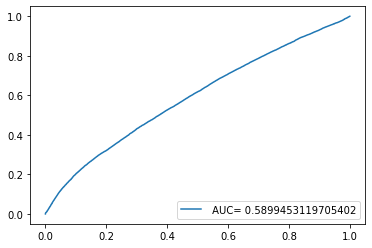

CPU times: total: 969 ms
Wall time: 884 ms


In [185]:
%%time
# Выводим показатели работы модели
mod_pred(logreg, X_train, y_train, X_test, y_test, 'Логистическая регрессия')
roc_auc_test(logreg, X_test, y_test)

####   4.1.2.2. Случайный лес 
- точность на тестовом сете - 96.7%, время обучения модели -  10min 19s, AUC - 0,5478

In [198]:
# Задаем модель
rf_clf = RandomForestClassifier(n_estimators=400, random_state=2)

In [199]:
%%time
# Обучаем модель
rf_clf.fit(X_train, y_train)

CPU times: total: 10min 8s
Wall time: 10min 19s


Модель  -- Случайный лес
Показатели точности модели --
TRAIN ACC: 0.9828845129335156
TEST ACC: 0.9671932727832512
Сonfusion_matrix -
 [[502531   2006]
 [ 15043    100]]


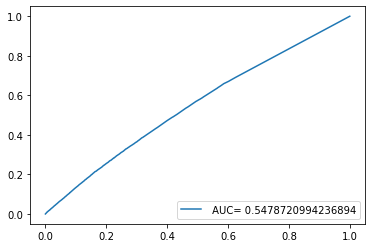

CPU times: total: 3min 45s
Wall time: 3min 48s


In [200]:
%%time
# Выводим показатели работы модели
mod_pred(res_clf, X_train, y_train, X_test, y_test, 'Случайный лес')
roc_auc_test(res_clf, X_test, y_test)

####   4.1.2.3. Многослойный персептрон 
- точность на тестовом сете - 97.1%, время обучения модели -  2min 12s, AUC - 0,5952

In [201]:
mlp = MLPClassifier(random_state=100, max_iter=500, hidden_layer_sizes=(200,40), activation = 'relu', solver ='sgd',
                  shuffle =False, warm_start=True)

In [202]:
%%time
# Обучаем модель
mlp.fit(X_train, y_train)

CPU times: total: 3min 8s
Wall time: 2min 12s


Модель  -- Многослойный персептрон
Показатели точности модели --
TRAIN ACC: 0.9709950469492473
TEST ACC: 0.970860914408867
Сonfusion_matrix -
 [[504537      0]
 [ 15143      0]]


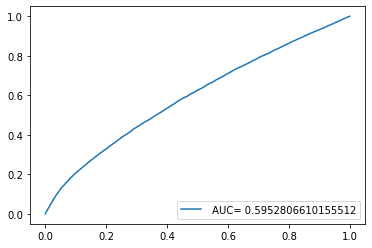

CPU times: total: 10.8 s
Wall time: 3.6 s


In [203]:
%%time
# Выводим показатели работы модели
mod_pred(mlp, X_train, y_train, X_test, y_test, 'Многослойный персептрон')
roc_auc_test(mlp, X_test, y_test)

###   4.1.3. Кросс-валидация на тренировочной выборке

In [174]:
%%time
cross_val(logreg, X_train, y_train, 5, 'Логистическая регрессия')

Показатели после кросс-валидации модели --- Логистическая регрессия
{'fit_time': array([14.67995191, 14.6848731 , 14.60414743, 14.51114488, 14.65306783]), 'score_time': array([0.05656409, 0.042032  , 0.03999925, 0.04100037, 0.05000114]), 'test_score': array([0.97099184, 0.97099585, 0.97099585, 0.97099585, 0.97099585])}
Cреднее значение точности модели -  97.09950469518888 % 
Стандартное отклонение точности модели - 1.6015237594313447e-06
CPU times: total: 6min 1s
Wall time: 2min 32s


array([0.97099184, 0.97099585, 0.97099585, 0.97099585, 0.97099585])

In [175]:
%%time
cross_val(rf_clf, X_train, y_train, 5, 'Случайный лес')

Показатели после кросс-валидации модели --- Случайный лес
{'fit_time': array([124.81642342, 125.02619171, 120.25575709, 115.79921412,
       116.97882819]), 'score_time': array([6.34564328, 7.1670301 , 5.95969939, 5.94091725, 5.9307282 ]), 'test_score': array([0.96725192, 0.96734662, 0.96713632, 0.96708272, 0.96712395])}
Cреднее значение точности модели -  96.72270667811536 % 
Стандартное отклонение точности модели - 6.535333863722966e-05
CPU times: total: 20min 40s
Wall time: 21min 2s


array([0.96722717, 0.96731776, 0.96713632, 0.96717756, 0.96727652])

In [176]:
%%time
cross_val(mlp, X_train, y_train, 5, 'Многослойный персептрон')

Показатели после кросс-валидации модели --- Многослойный персептрон
{'fit_time': array([165.31928205, 184.31417179, 170.51975727, 208.55763936,
       188.95407367]), 'score_time': array([0.55474663, 0.56445813, 0.572052  , 0.59001875, 0.57270455]), 'test_score': array([0.97100421, 0.97099997, 0.97099585, 0.97099585, 0.97099172])}
Cреднее значение точности модели -  97.09892741607031 % 
Стандартное отклонение точности модели - 1.741973724077876e-05
CPU times: total: 42min
Wall time: 30min 18s


array([0.97099184, 0.9709876 , 0.97099585, 0.97101234, 0.97095874])

###  4.1.4. Выбор лучшей модели на выборке 1

#####  Логистическая регрессия 
- точность на тестовом сете - 97,1%, время обучения модели - 1min 39s, AUC - 0,59
- После кросс-валидации: среднее значение точности модели -  97.09950469518888 %, стандартное отклонение точности модели - 1.6015237594313447e-06, Wall time кросс-валидации - 2min 32s
#####  Случайный лес 
- точность на тестовом сете - 96.7%, время обучения модели -  10min 19s, AUC - 0,5478
- После кросс-валидации: среднее значение точности модели -  97.09950469518888 % %, стандартное отклонение точности модели - 6.535333863722966e-05, Wall time кросс-валидации - 21min 2s
#####  Многослойный персептрон 
- точность на тестовом сете - 97.1%, время обучения модели -  2min 12s, AUC - 0,5952
- После кросс-валидации: среднее значение точности модели -  97.09892741607031 %, стандартное отклонение точности модели - 1.741973724077876e-05, Wall time кросс-валидации - 30min 18s
#### ЛУчший результат для первой выборки - МП, т.к. AUC выше, а это очень важная характеристик

### 4.2. Исследование моделей на второй выборке (с сокращением признаков, без моделей авто)

### 4.2.1. Подготовка данных

#### 4.2.1.1. Сокращение признаков

In [204]:
%%time
df = pd.read_csv('data/df_fe_mod.csv')
df_prepared = df.drop(['session_id'], axis=1)
df_prepared['CR_result'] = df_prepared['CR_result'].astype(float)
X = df_prepared.drop(['CR_result'], axis=1)
y = df_prepared['CR_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

CPU times: total: 12.7 s
Wall time: 13.1 s


In [205]:
df_vars = df_prepared.columns.values.tolist()
y = ['y']
X = [i for i in df_vars if i not in y]

In [206]:
%%time
logreg = LogisticRegression()
rfe = RFE(logreg, step = 20)
rfe = rfe.fit(X_train, y_train.values.ravel())

CPU times: total: 2min 22s
Wall time: 1min


In [207]:
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
 False False  True False False  True  True  True False False  True False
 False False False False False False False  True False False False False
 False False False False False  True  True  True False  True False False
 False False False False  True False  True False  True  True False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True False False  True  True False False  True
 False False False False  True  True  True  True  True  True  True  True
 False]
[1 1 1 1 1 1 1 1 1 1 1 1 3 4 1 3 3 1 1 1 2 4 1 2 3 4 3 4 4 2 3 1 3 4 4 4 4
 2 3 4 2 1 1 1 4 1 4 4 3 4 4 4 1 4 1 3 1 1 3 4 4 2 4 3 3 3 1 1 1 1 1 1 1 1
 1 1 1 3 2 1 1 2 2 1 3 3 3 3 1 1 1 1 1 1 1 1 3]


In [208]:
# Перечень столбцов с рейтингом =1, их получилось 48, т.е вдвое меньше, чем в начальном перечне, оставим их в перечне
a = rfe.ranking_
b = []
for i in range(len(a)):
    if a[i] == 1:
        b.append(i)
print('Количество признаков в начальной выборке: ', len(df_prepared.columns))
print('Количество признаков в выборке с сокращенными признаками: ',len(b))
c = df_prepared.columns
d = []
d = [c[i] for i in b]
print(d[0:5])

Количество признаков в начальной выборке:  98
Количество признаков в выборке с сокращенными признаками:  48
['device_browser__Chrome', 'device_browser__Safari', 'device_browser__YaBrowser', 'device_browser__other_browser', 'device_category_desktop']


#### 4.2.1.2. Повторная разделение выборок после рекурсии признаков

In [209]:
df_prepared_ = df_prepared[d]
df_prepared_['CR_result'] = df_prepared['CR_result']
X = df_prepared_.drop(['CR_result'], axis=1)
y = df_prepared_['CR_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###   4.2.2.  Обучение моделей на второй выборке

####   4.2.2.1.  Логистическая регрессия 
- точность на тестовом сете - 97,1%, время обучения модели - 28.9 s, AUC - 0,59

In [210]:
logreg = LogisticRegression(random_state=100, max_iter=400, intercept_scaling=100, penalty='l2', solver='sag')

In [211]:
%%time
logreg.fit(X_train, y_train)

CPU times: total: 1min 46s
Wall time: 28.9 s


Модель  -- Логистическая регрессия
Показатели точности модели --
TRAIN ACC: 0.9709950469492473
TEST ACC: 0.970860914408867
Сonfusion_matrix -
 [[504537      0]
 [ 15143      0]]


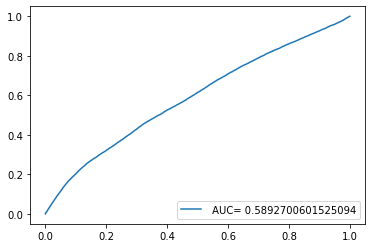

CPU times: total: 891 ms
Wall time: 807 ms


In [212]:
%%time
mod_pred(logreg, X_train, y_train, X_test, y_test, 'Логистическая регрессия')
roc_auc_test(logreg, X_test, y_test)

####   4.2.2.2. Случайный лес 
- точность на тестовом сете - 96.7%, время обучения модели - 7min 23s, AUC - 0,5240

In [213]:
rf_clf = RandomForestClassifier(n_estimators=400, random_state=2)

In [214]:
%%time
rf_clf.fit(X_train, y_train)

CPU times: total: 7min 13s
Wall time: 7min 23s


Модель  -- Случайный лес
Показатели точности модели --
TRAIN ACC: 0.9750871278408294
TEST ACC: 0.9686210745073892
Сonfusion_matrix -
 [[503283   1254]
 [ 15053     90]]


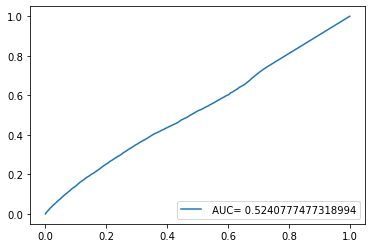

CPU times: total: 3min 7s
Wall time: 3min 11s


In [215]:
%%time
mod_pred(rf_clf, X_train, y_train, X_test, y_test, 'Случайный лес')
roc_auc_test(rf_clf, X_test, y_test)

####   4.2.2.3. Многослойный персептрон 
- точность на тестовом сете - 97,1%, время обучения модели - 2min 6s, AUC - 0,5965

In [216]:
mlp = MLPClassifier(random_state=100, max_iter=500, hidden_layer_sizes=(200,40), activation = 'relu', solver ='sgd',
                  shuffle =False, warm_start=True)

In [217]:
%%time
mlp.fit(X_train, y_train)

CPU times: total: 2min 51s
Wall time: 2min 6s


Модель  -- Многослойный персептрон
Показатели точности модели --
TRAIN ACC: 0.9709950469492473
TEST ACC: 0.970860914408867
Сonfusion_matrix -
 [[504537      0]
 [ 15143      0]]


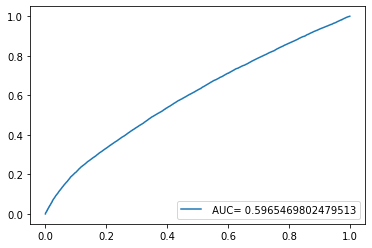

CPU times: total: 9.31 s
Wall time: 3.42 s


In [218]:
%%time
mod_pred(mlp, X_train, y_train, X_test, y_test, 'Многослойный персептрон')
roc_auc_test(mlp, X_test, y_test)

###   4.2.3. Кросс-валидация на тренировочной выборке

In [309]:
%%time
cross_val(logreg, X_train, y_train, 5, 'Логистическая регрессия')

Показатели после кросс-валидации модели --- Логистическая регрессия
{'fit_time': array([ 9.80300069, 10.9010036 , 11.23803616, 10.67900014, 10.25000048]), 'score_time': array([0.03399968, 0.03899765, 0.03696418, 0.03100109, 0.03400016]), 'test_score': array([0.97085165, 0.97085153, 0.97085153, 0.97085153, 0.97085153])}
Cреднее значение точности модели -  97.0851551972317 % 
Стандартное отклонение точности модели - 4.8076385361639486e-08
CPU times: total: 3min 11s
Wall time: 1min 46s


array([0.97085165, 0.97085153, 0.97085153, 0.97085153, 0.97085153])

In [310]:
%%time
cross_val(rf_clf, X_train, y_train, 5, 'Случайный лес')

Показатели после кросс-валидации модели --- Случайный лес
{'fit_time': array([87.20799756, 90.52699876, 77.01199889, 80.67499971, 78.3059988 ]), 'score_time': array([4.98400164, 4.3310008 , 4.34600139, 4.41800356, 4.32900262]), 'test_score': array([0.97024551, 0.97004746, 0.97006395, 0.97010519, 0.97018766])}
Cреднее значение точности модели -  97.01250054978439 % 
Стандартное отклонение точности модели - 7.32068143064438e-05
CPU times: total: 14min 12s
Wall time: 14min 20s


array([0.9702084 , 0.9700722 , 0.97003921, 0.97008869, 0.97021652])

In [311]:
%%time
cross_val(mlp, X_train, y_train, 5, 'Многослойный персептрон')

Показатели после кросс-валидации модели --- Многослойный персептрон
{'fit_time': array([ 97.24302983, 113.33143425, 158.04499912, 123.57800221,
       137.80303049]), 'score_time': array([0.32900095, 0.37200046, 0.43799949, 0.5099988 , 0.40496826]), 'test_score': array([0.97085165, 0.97085153, 0.97085153, 0.97085565, 0.97085153])}
Cреднее значение точности модели -  97.08515519757175 % 
Стандартное отклонение точности модели - 2.5700368121794195e-06
CPU times: total: 20min 49s
Wall time: 21min 29s


array([0.97084752, 0.97085153, 0.97085153, 0.97085565, 0.97085153])

###   4.2.4. Выводы по лучшей модели выборки 2

#####  Логистическая регрессия 
- точность на тестовом сете - 97,1%, время обучения модели - 28.9 s, AUC - 0,59
- После кросс-валидации: среднее значение точности модели -  97.0851551972317 %, стандартное отклонение точности модели - 4.8076385361639486e-08, Wall time кросс-валидации - 1min 46s
#####  Случайный лес 
- точность на тестовом сете - 96.7%, время обучения модели - 7min 23s, AUC - 0,5240
- После кросс-валидации: среднее значение точности модели -  97.01250054978439 %, стандартное отклонение точности модели - 7.32068143064438e-05, Wall time кросс-валидации - 14min 20s
#####  Многослойный персептрон 
- точность на тестовом сете - 97,1%, время обучения модели - 2min 6s, AUC - 0,5965
- После кросс-валидации: среднее значение точности модели -  97.09110401621092 %, стандартное отклонение точности модели - 2.3562399123822075e-06, Wall time кросс-валидации - 21min 29s

После сокращения количества признаков, точность моделей практически не улучшилась (кроме случайного леса), но общее время работы по всем моделям существенно снизилось
Целесообразно проводить сокращение признаков на этапе подготовки данных
Но ухудшился AUC
Лучший результат для второй выборки - МП, т.к. лучший AUC, несмотря на ухудшение времени

## 4.3. Исследование моделей на третьей выборке 
(с сокращением признаков, с моделями авто)

### 4.3.1. Подготовка данных
#### 4.3.1.1.  Добавление моделей авто

In [100]:
df = pd.read_csv('data/df_fe_mod.csv')
df1 = pd.read_csv('data/session_with_model_auto_cat.csv')
df_join = pd.merge(df, df1, how='left') 
df_join.shape

(1732266, 245)

In [101]:
df_join = df_join.fillna(0)

In [102]:
df_prepared = df_join.drop(['session_id'], axis=1)
df_prepared['CR_result'] = df_prepared['CR_result'].astype(float)
print(len(df_prepared.columns))
X = df_prepared.drop(['CR_result'], axis=1)
y = df_prepared['CR_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

244


#### 4.3.1.2. Сокращение признаков

In [103]:
df_vars = df_prepared.columns.values.tolist()
y = ['y']
X = [i for i in df_vars if i not in y]
logreg = LogisticRegression()
rfe = RFE(logreg, step = 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
 False False  True False False  True  True  True False False  True  True
 False False False False  True False False False False False False False
 False False False False False  True  True  True False  True False False
 False False False False  True False  True  True  True False False  True
 False  True False False False False  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True False  True False False False  True False
 False False  True False  True False  True False False False False  True
 False False False False False False  True False False False False False
 False  True False False  True False False False False  True False False
  True False  True  True  True False  True  True False False False False
 False False  True False  True  True  True  True  T

In [104]:
# Перечень столбцов с рейтингом =1, их получилось 121, т.е вдвое меньше, чем в начальном перечне, оставим их в перечне
a = rfe.ranking_
b = []
for i in range(len(a)):
    if a[i] == 1:
        b.append(i)
print('Количество признаков в начальной выборке: ', len(df_prepared.columns))
print('Количество признаков в выборке с сокращенными признаками: ',len(b))
c = df_prepared.columns
d = []
d = [c[i] for i in b]
print(d[0:5])

Количество признаков в начальной выборке:  244
Количество признаков в выборке с сокращенными признаками:  121
['device_browser__Chrome', 'device_browser__Safari', 'device_browser__YaBrowser', 'device_browser__other_browser', 'device_category_desktop']


#### 4.3.1.3. Повторное разделение выборок после рекурсии признаков

In [105]:
print(d)

['device_browser__Chrome', 'device_browser__Safari', 'device_browser__YaBrowser', 'device_browser__other_browser', 'device_category_desktop', 'device_category_mobile', 'device_category_tablet', 'device_brand__Apple', 'device_brand__Huawei', 'device_brand__Samsung', 'device_brand__Xiaomi', 'device_brand__other_bran', 'utm_medium_app', 'utm_medium_blogger_channel', 'utm_medium_blogger_header', 'utm_medium_blogger_stories', 'utm_medium_clicks', 'utm_medium_cpa', 'utm_medium_email', 'utm_medium_organic', 'utm_medium_other', 'utm_medium_outlook', 'utm_medium_post', 'utm_medium_referral', 'utm_medium_smartbanner', 'utm_medium_smm', 'utm_medium_sms', 'utm_medium_stories', 'utm_medium_tg', 'utm_source__BHcvLfOaCWvWTykYqHVe', 'utm_source__ZpYIoDJMcFzVoPFsHGJL', 'utm_source__bByPQxmDaMXgpHeypKSM', 'utm_source__fDLlAcSmythWSCVMvqvL', 'utm_source__kjsLglQLzykiRbcDiGcD', 'utm_source__other_source', 'utm_campaign__FTjNLDyTrXaWYgZymFkV', 'utm_campaign__LEoPHuyFvzoNfnzGgfcd', 'utm_campaign__LTuZkdKfxR

In [106]:
df_prepared_ = df_prepared[d]
df_prepared_['CR_result'] = df_prepared['CR_result']
X = df_prepared_.drop(['CR_result'], axis=1)
y = df_prepared_['CR_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [73]:
df_prepared_.to_csv('data/dataset_for_use_model.csv', index=False)

In [37]:
df = pd.read_csv('data/dataset_for_use_model.csv')
X = df.drop(['CR_result'], axis=1)
y = df['CR_result']

###   4.3.2.  Обучение моделей на третьей выборке

####   4.3.2.1.  Логистическая регрессия 
- точность на тестовом сете - 97,1%, время обучения модель - 24.5 s, AUC - 0,6742

In [74]:
logreg = LogisticRegression()

In [75]:
%%time
logreg.fit(X_train, y_train)

CPU times: total: 1min 1s
Wall time: 24.5 s


Модель  -- Логистическая регрессия
Показатели точности модели --
TRAIN ACC: 0.9707995968945707
TEST ACC: 0.9706223060344827
Сonfusion_matrix -
 [[504295    242]
 [ 15025    118]]


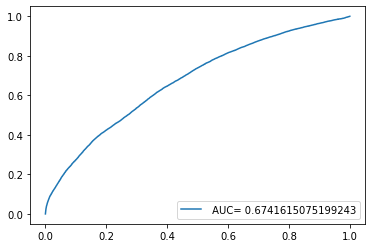

CPU times: total: 2.12 s
Wall time: 3.85 s


In [76]:
%%time
mod_pred(logreg, X_train, y_train, X_test, y_test, 'Логистическая регрессия')
roc_auc_test(logreg, X_test, y_test)

####   4.3.2.2. Случайный лес 
- точность на тестовом сете - 96,8%, время обучения модели - 9min 40s, AUC - 0,6204

Модель  -- Случайный лес
Показатели точности модели --
TRAIN ACC: 0.9860859353480907
TEST ACC: 0.9677378386699508
Сonfusion_matrix -
 [[502688   1849]
 [ 14917    226]]


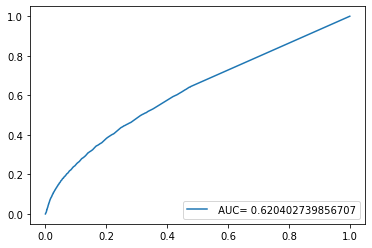

CPU times: total: 9min 29s
Wall time: 9min 40s


In [77]:
%%time
rf_clf = RandomForestClassifier()
# rf_clf = RandomForestClassifier(n_estimators=400, random_state=2)
rf_clf.fit(X_train, y_train)
mod_pred(rf_clf, X_train, y_train, X_test, y_test, 'Случайный лес')
roc_auc_test(rf_clf, X_test, y_test)

####   4.3.2.3. Многослойный персептрон 
- точность на тестовом сете - 97,1%, время обучения модели - 3min 42s, AUC - 0,6951

Модель  -- Многослойный персептрон
Показатели точности модели --
TRAIN ACC: 0.9710775153267479
TEST ACC: 0.970755080049261
Сonfusion_matrix -
 [[504393    144]
 [ 15054     89]]


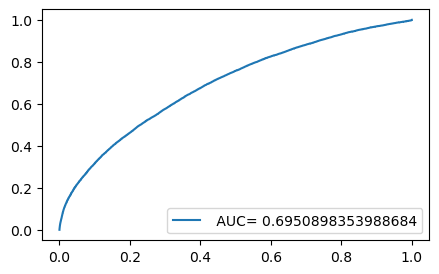

CPU times: total: 21min 35s
Wall time: 3min 42s


In [115]:
%%time
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mod_pred(mlp, X_train, y_train, X_test, y_test, 'Многослойный персептрон')
roc_auc_test(mlp, X_test, y_test)

###   4.3.3. Кросс-валидация на тренировочной выборке

In [79]:
%%time
cross_val(logreg, X_train, y_train, 5, 'Логистическая регрессия')

Показатели после кросс-валидации модели --- Логистическая регрессия
{'fit_time': array([20.41700244, 20.47100496, 20.24596071, 20.20452642, 19.44999576]), 'score_time': array([0.05999708, 0.09699559, 0.07800126, 0.06700158, 0.0630002 ]), 'test_score': array([0.97083928, 0.97078968, 0.97074844, 0.97068659, 0.97087627])}
Cреднее значение точности модели -  97.0788051279475 % 
Стандартное отклонение точности модели - 6.674148077506985e-05
CPU times: total: 8min 10s
Wall time: 3min 24s


array([0.97083928, 0.97078968, 0.97074844, 0.97068659, 0.97087627])

In [80]:
%%time
cross_val(rf_clf, X_train, y_train, 5, 'Случайный лес')

Показатели после кросс-валидации модели --- Случайный лес
{'fit_time': array([335.52699733, 335.95046329, 349.83399248, 342.64696336,
       349.87003565]), 'score_time': array([15.18296409, 12.24299812, 15.4419632 , 14.17399645, 15.38600659]), 'test_score': array([0.96780445, 0.9678002 , 0.96780432, 0.96777545, 0.96780432])}
Cреднее значение точности модели -  96.7788676415612 % 
Стандартное отклонение точности модели - 6.37494917307669e-05
CPU times: total: 59min 5s
Wall time: 1h 46s


array([0.96780858, 0.96788266, 0.96775896, 0.96768886, 0.96780432])

In [81]:
%%time
cross_val(mlp, X_train, y_train, 5, 'Многослойный персептрон')

Показатели после кросс-валидации модели --- Многослойный персептрон
{'fit_time': array([411.84496021, 379.80205965, 497.12242937, 686.71372557,
       500.07654524]), 'score_time': array([0.66299534, 0.42500019, 0.70100164, 0.49899888, 0.56699944]), 'test_score': array([0.97068259, 0.9708474 , 0.97090101, 0.9707938 , 0.97044331])}
Cреднее значение точности модели -  97.08861886582223 % 
Стандартное отклонение точности модели - 2.721201910195292e-05
CPU times: total: 1h 39min 29s
Wall time: 1h 26min 34s


array([0.97092587, 0.97084328, 0.97090101, 0.97088039, 0.97088039])

###   4.3.4. Выводы по лучшей модели выборки 3

#####  Логистическая регрессия 
- точность на тестовом сете - 97,1%, время обучения модель - 24.5 s, AUC - 0,6742
- После кросс-валидации: среднее значение точности модели -  97.0788051279475 %, стандартное отклонение точности модели - 6.674148077506985e-05, Wall time кросс-валидации - 3min 24s
#####  Случайный лес 
- точность на тестовом сете - 96,8%, время обучения модели - 9min 40s, AUC - 0,6204
- После кросс-валидации: среднее значение точности модели -  96.7788676415612 %, стандартное отклонение точности модели - 6.37494917307669e-05, Wall time кросс-валидации - 1h 46s
#####  Многослойный персептрон 
- точность на тестовом сете - 97,1%, время обучения модели - 3min 42s, AUC - 0,6951
- После кросс-валидации: среднее значение точности модели -  97.08861886582223 %, стандартное отклонение точности модели - 2.721201910195292e-05, Wall time кросс-валидации - 1h 26min 34s

In [ ]:
%%time
# Кросс-валидация на тестовой выборке
cross_val(mlp, X_test, y_test, 5, 'Многослойный персептрон')

Показатели после кросс-валидации модели --- Многослойный персептрон
{'fit_time': array([398.20699978, 608.03700066, 613.19554043, 560.16420245,
       720.21503091]), 'score_time': array([0.3239994 , 0.28500247, 0.29200077, 0.33199763, 0.20299935]), 'test_score': array([0.97021244, 0.97013547, 0.9701932 , 0.97044335, 0.97023168])}


# 5. RESULTS

##  5.1. Общие выводы

##### По результатам -
- учитывая тот факт, что пороговое значение AUC удалось превысить только в случае третьей выборки, рассматриваем результаты только по ней, несмотря на то, что в первых двух выборках accuracy получилась выше
- таким образом, целесообразно использовать порядок сбора третьей выборки, т.е. добавлять модели авто и проводить сокращение количества признаков, убирая малозначимые
- переобучения модели не установлено по всем трем методам, поэтому данный фактор не рассматриваем далее
- По совокупности всех признаков лучшая модель по методу Многослойного персептрона, ее выбираем и работаем с ней далее
    - точность на тестовом сете - 97,1%, время обучения модели - 3min 42s, AUC - 0,6951
    - После кросс-валидации: среднее значение точности модели -  97.08861886582223 %, стандартное отклонение точности модели - 2.721201910195292e-05, Wall time кросс-валидации - 1h 26min 34s

##  5.2. Обучение модели на всем датасете

TEST ACC MLP RESULTS: 0.9709299841941134
Сonfusion_matrix -
 [[1681069     883]
 [  49474     840]]


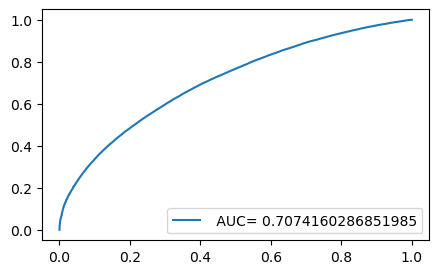

CPU times: total: 23min 35s
Wall time: 4min 2s


In [120]:
%%time
mlp.fit(X, y)
res_model = mlp.predict(X)
print(f'TEST ACC MLP RESULTS: {accuracy_score(y, res_model)}')
print('Сonfusion_matrix -\n', confusion_matrix(y, res_model))
roc_auc_test(mlp, X, y)

#### По итогам обучения модели на всем датасете - 
- точность на тестовом сете - 97,1%, время обучения модели - 4min 2s, AUC - 0,7074

##  5.3. Подготовка к общему использованию

In [129]:
# Сериализация модели в файл
filename = 'ML_proect_auto_pod_MLP.pickle'
with open(filename, 'wb') as file:
    pickle.dump(mlp, file) 

##  5.4. Перечень действий

1. Работа с файлом `ga_hits.csv` - события в рамках визита
    - 1.1. Расчет параметра CR (расчет по целевому действию, группировка по ID, расчет суммарного CR, вывод итогового бинарного CR), файл - `df_group_CR_sum`
    - 1.2. Вывод марки и модели авто (выделение модели, группировка данных, стандартизация категориальной переменной) , файл - `session_with_model_auto_cat.csv`
2.  Работа с файлом `ga_hits.csv` - события в рамках визита
    - 2.1. Присоединение бинарного показателя конверсии CR
    - 2.2. Отработка нулевых и отсутствующих данных
        - 2.2.1. Выделение столбцов с нулевыми и отсутствующими данными
        - 2.2.2. Удаление столбцов, в которых более 50% данных нулевые или отсутствующие
        - 2.2.3. Замена данных на моды (сначала по группировке из матрицы группировки), далее на моду столбца
        - 2.2.4. Проверка, что все данные есть и ненулевые
        - 2.2.4. Преобразование данных ('date', 'client_id')
3. Feature Engeneering, формирование датасета для моделирования
    - 3.1. Формирование доп. столбцов - 'CR_result'(0/1), 'org_traffic', 'advertising_social_NW, 'month','dayofweek'
    - 3.2. Сокращение категориальных - 'device_browser'(4), 'device_brand'(5), 'utm_campaign'(6),  'utm_source'(6), 'geo_city'(11) по принципу выделения максимальных и объединения остальных данных
    - 3.3. Удаление "лишних" столбцов - 'CR_sum', 'geo_country', 'device_brand', 'device_browser', 'device_screen_resolution', 'visit_date', 'utm_adcontent', 'utm_campaign', 'utm_source', 'geo_city', 'client_id'
    - 3.4. Стандартизация категориальных и количественных переменных
    - 3.5. Добавление категориального признака модели авто
    - 3.6. Удаление незначимых столбцов
    - 3.7. Сверка итоговых столбцов для использования модели (c витриной формата `dataset_for_use_model.csv`)
4. Применение модели

In [141]:
# Алгоритм применения модели - читаем файл, определяем Х, открываем модель из pickle, применяем модель и записываем результат

df = pd.read_csv('data/dataset_for_use_model.csv')

X = df.drop(['CR_result'], axis=1)

with open('ML_proect_auto_pod_MLP.pickle', 'rb') as f:
    model_from_pickle = pickle.load(f)

res_model_ = model_from_pickle.predict(X)

In [142]:
print('Сonfusion_matrix -\n', confusion_matrix(df['CR_result'], res_model_))

Сonfusion_matrix -
 [[1681069     883]
 [  49474     840]]


In [143]:
print('Длина списка прогноза -',len(res_model_))
print('Размерность датасета для прогноза -', df.shape)
print('Кол-во CR_result= 1 -', df['CR_result'].sum())
df['res'] = res_model_
df['err'] = np.where(df['CR_result'] !=df['res'], 1, 0)
print('Кол-во прогнозов= 1 -', df['res'].sum())
print('Кол-во отличий в  CR_result и прогнозе -', df[df['err'] == 1].shape)

Длина списка прогноза - 1732266
Размерность датасета для прогноза - (1732266, 121)
Кол-во CR_result= 1 - 50314.0
Кол-во прогнозов= 1 - 1723.0
Кол-во отличий в  CR_result и прогнозе - (50357, 123)


- 50357 / 1732266 = 2,9%
- 1723  / 1732266 = 0,1 %
Таким образом, несмотря на неплохие показатели точности модели, предсказание конверсии крайне низкое - занижено почти в 30 раз